In [1]:
# Importar librerías
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imgaug
import os
from numba import cuda 

import datetime
import coco

import logging
from collections import OrderedDict
import multiprocessing
import keras
import keras.backend as K
import keras.layers as KL
import keras.engine as KE
import keras.models as KM

# Dirección del proyecto
ROOT_DIR = os.path.abspath("../../")

# Importar algunas funciones
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from coco import evaluate_coco
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 

# Ruta para guardar los logs y el modelo entrenado
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Ruta para obtener el archivo de pesos
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Utilizar los pesos de coco
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


### Mask RCNN - Implementación

In [2]:
class BatchNorm(KL.BatchNormalization):
    """Extends the Keras BatchNormalization class to allow a central place
    to make changes if needed.

    Batch normalization has a negative effect on training if batches are small
    so this layer is often frozen (via setting in Config class) and functions
    as linear layer.
    """
    def call(self, inputs, training=None):
        """
        Note about training values:
            None: Train BN layers. This is the normal mode
            False: Freeze BN layers. Good when batch size is small
            True: (don't use). Set layer in training mode even when making inferences
        """
        return super(self.__class__, self).call(inputs, training=training)

############################################################
#  MaskRCNN Class
############################################################
## Clase que empaqueta y tiene los métodos para generar el
## modelo MaskRCNN en modo Entrenamiento y modo Inferencia.
## EL modelo MaskRCNN genera tres salidas:
## 1. La clase de predicción.
## 2. El cuadro delimitador (Bounding box)
## 3. La máscara de la imagen (Mask)
############################################################
class MaskRCNN():
    """Encapsulates the Mask RCNN model functionality.
    The actual Keras model is in the keras_model property.
    """

    def __init__(self, mode, config, model_dir):
        """
        mode: Either "training" or "inference"
        config: A Sub-class of the Config class
        model_dir: Directory to save training logs and trained weights
        """
        assert mode in ['training', 'inference']
        self.mode = mode
        self.config = config
        self.model_dir = model_dir
        self.set_log_dir()
        self.keras_model = self.build(mode=mode, config=config)

    def build(self, mode, config):
        """Build Mask R-CNN architecture.
            input_shape: The shape of the input image.
            mode: Either "training" or "inference". The inputs and
                outputs of the model differ accordingly.
        """
        assert mode in ['training', 'inference']

        # Image size must be dividable by 2 multiple times
        h, w = config.IMAGE_SHAPE[:2]
        if h / 2**6 != int(h / 2**6) or w / 2**6 != int(w / 2**6):
            raise Exception("Image size must be dividable by 2 at least 6 times "
                            "to avoid fractions when downscaling and upscaling."
                            "For example, use 256, 320, 384, 448, 512, ... etc. ")

        # Inputs
        input_image = KL.Input(
            shape=[None, None, config.IMAGE_SHAPE[2]], name="input_image")
        input_image_meta = KL.Input(shape=[config.IMAGE_META_SIZE],
                                    name="input_image_meta")
        if mode == "training":
            # RPN GT
            input_rpn_match = KL.Input(
                shape=[None, 1], name="input_rpn_match", dtype=tf.int32)
            input_rpn_bbox = KL.Input(
                shape=[None, 4], name="input_rpn_bbox", dtype=tf.float32)

            # Detection GT (class IDs, bounding boxes, and masks)
            # 1. GT Class IDs (zero padded)
            input_gt_class_ids = KL.Input(
                shape=[None], name="input_gt_class_ids", dtype=tf.int32)
            # 2. GT Boxes in pixels (zero padded)
            # [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in image coordinates
            input_gt_boxes = KL.Input(
                shape=[None, 4], name="input_gt_boxes", dtype=tf.float32)
            # Normalize coordinates
            gt_boxes = KL.Lambda(lambda x: norm_boxes_graph(
                x, K.shape(input_image)[1:3]))(input_gt_boxes)
            # 3. GT Masks (zero padded)
            # [batch, height, width, MAX_GT_INSTANCES]
            if config.USE_MINI_MASK:
                input_gt_masks = KL.Input(
                    shape=[config.MINI_MASK_SHAPE[0],
                           config.MINI_MASK_SHAPE[1], None],
                    name="input_gt_masks", dtype=bool)
            else:
                input_gt_masks = KL.Input(
                    shape=[config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], None],
                    name="input_gt_masks", dtype=bool)
        elif mode == "inference":
            # Anchors in normalized coordinates
            input_anchors = KL.Input(shape=[None, 4], name="input_anchors")

        # Build the shared convolutional layers.
        # Bottom-up Layers
        # Returns a list of the last layers of each stage, 5 in total.
        # Don't create the thead (stage 5), so we pick the 4th item in the list.
        ############################################################
        ## Comentarios del G6:
        ############################################################
        ## Paso 1. 
        ## Se utiliza una red neuronal convolucional resnet 50 o 101
        ## para extraer el mapa de carácterísticas inicial de las
        ## imagenes.
        ############################################################
        
        if callable(config.BACKBONE):
            _, C2, C3, C4, C5 = config.BACKBONE(input_image, stage5=True,
                                                train_bn=config.TRAIN_BN)
        else:
            _, C2, C3, C4, C5 = resnet_graph(input_image, config.BACKBONE,
                                             stage5=True, train_bn=config.TRAIN_BN)
        # Top-down Layers
        # TODO: add assert to varify feature map sizes match what's in config
        P5 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c5p5')(C5)
        P4 = KL.Add(name="fpn_p4add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p5upsampled")(P5),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c4p4')(C4)])
        P3 = KL.Add(name="fpn_p3add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p4upsampled")(P4),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c3p3')(C3)])
        P2 = KL.Add(name="fpn_p2add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p3upsampled")(P3),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c2p2')(C2)])
        # Attach 3x3 conv to all P layers to get the final feature maps.
        P2 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p2")(P2)
        P3 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p3")(P3)
        P4 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p4")(P4)
        P5 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p5")(P5)
        # P6 is used for the 5th anchor scale in RPN. Generated by
        # subsampling from P5 with stride of 2.
        P6 = KL.MaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)

        # Note that P6 is used in RPN, but not in the classifier heads.
        rpn_feature_maps = [P2, P3, P4, P5, P6]
        mrcnn_feature_maps = [P2, P3, P4, P5]

        # Anchors
        if mode == "training":
            anchors = self.get_anchors(config.IMAGE_SHAPE)
            # Duplicate across the batch dimension because Keras requires it
            # TODO: can this be optimized to avoid duplicating the anchors?
            anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)
            # A hack to get around Keras's bad support for constants
            anchors = KL.Lambda(lambda x: tf.Variable(anchors), name="anchors")(input_image)
        else:
            anchors = input_anchors

        # RPN Model
        rpn = build_rpn_model(config.RPN_ANCHOR_STRIDE,
                              len(config.RPN_ANCHOR_RATIOS), config.TOP_DOWN_PYRAMID_SIZE)
        # Loop through pyramid layers
        layer_outputs = []  # list of lists
        for p in rpn_feature_maps:
            layer_outputs.append(rpn([p]))
        # Concatenate layer outputs
        # Convert from list of lists of level outputs to list of lists
        # of outputs across levels.
        # e.g. [[a1, b1, c1], [a2, b2, c2]] => [[a1, a2], [b1, b2], [c1, c2]]
        output_names = ["rpn_class_logits", "rpn_class", "rpn_bbox"]
        outputs = list(zip(*layer_outputs))
        outputs = [KL.Concatenate(axis=1, name=n)(list(o))
                   for o, n in zip(outputs, output_names)]

        rpn_class_logits, rpn_class, rpn_bbox = outputs

        # Generate proposals
        # Proposals are [batch, N, (y1, x1, y2, x2)] in normalized coordinates
        # and zero padded.
        proposal_count = config.POST_NMS_ROIS_TRAINING if mode == "training"\
            else config.POST_NMS_ROIS_INFERENCE
        rpn_rois = ProposalLayer(
            proposal_count=proposal_count,
            nms_threshold=config.RPN_NMS_THRESHOLD,
            name="ROI",
            config=config)([rpn_class, rpn_bbox, anchors])

        if mode == "training":
            # Class ID mask to mark class IDs supported by the dataset the image
            # came from.
            active_class_ids = KL.Lambda(
                lambda x: parse_image_meta_graph(x)["active_class_ids"]
                )(input_image_meta)

            if not config.USE_RPN_ROIS:
                # Ignore predicted ROIs and use ROIs provided as an input.
                input_rois = KL.Input(shape=[config.POST_NMS_ROIS_TRAINING, 4],
                                      name="input_roi", dtype=np.int32)
                # Normalize coordinates
                target_rois = KL.Lambda(lambda x: norm_boxes_graph(
                    x, K.shape(input_image)[1:3]))(input_rois)
            else:
                target_rois = rpn_rois

            # Generate detection targets
            # Subsamples proposals and generates target outputs for training
            # Note that proposal class IDs, gt_boxes, and gt_masks are zero
            # padded. Equally, returned rois and targets are zero padded.
            rois, target_class_ids, target_bbox, target_mask =\
                DetectionTargetLayer(config, name="proposal_targets")([
                    target_rois, input_gt_class_ids, gt_boxes, input_gt_masks])

            # Network Heads
            # TODO: verify that this handles zero padded ROIs
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
                fpn_classifier_graph(rois, mrcnn_feature_maps, input_image_meta,
                                     config.POOL_SIZE, config.NUM_CLASSES,
                                     train_bn=config.TRAIN_BN,
                                     fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

            mrcnn_mask = build_fpn_mask_graph(rois, mrcnn_feature_maps,
                                              input_image_meta,
                                              config.MASK_POOL_SIZE,
                                              config.NUM_CLASSES,
                                              train_bn=config.TRAIN_BN)

            # TODO: clean up (use tf.identify if necessary)
            output_rois = KL.Lambda(lambda x: x * 1, name="output_rois")(rois)

            # Losses
            rpn_class_loss = KL.Lambda(lambda x: rpn_class_loss_graph(*x), name="rpn_class_loss")(
                [input_rpn_match, rpn_class_logits])
            rpn_bbox_loss = KL.Lambda(lambda x: rpn_bbox_loss_graph(config, *x), name="rpn_bbox_loss")(
                [input_rpn_bbox, input_rpn_match, rpn_bbox])
            class_loss = KL.Lambda(lambda x: mrcnn_class_loss_graph(*x), name="mrcnn_class_loss")(
                [target_class_ids, mrcnn_class_logits, active_class_ids])
            bbox_loss = KL.Lambda(lambda x: mrcnn_bbox_loss_graph(*x), name="mrcnn_bbox_loss")(
                [target_bbox, target_class_ids, mrcnn_bbox])
            mask_loss = KL.Lambda(lambda x: mrcnn_mask_loss_graph(*x), name="mrcnn_mask_loss")(
                [target_mask, target_class_ids, mrcnn_mask])

            # Model
            inputs = [input_image, input_image_meta,
                      input_rpn_match, input_rpn_bbox, input_gt_class_ids, input_gt_boxes, input_gt_masks]
            if not config.USE_RPN_ROIS:
                inputs.append(input_rois)
            outputs = [rpn_class_logits, rpn_class, rpn_bbox,
                       mrcnn_class_logits, mrcnn_class, mrcnn_bbox, mrcnn_mask,
                       rpn_rois, output_rois,
                       rpn_class_loss, rpn_bbox_loss, class_loss, bbox_loss, mask_loss]
            model = KM.Model(inputs, outputs, name='mask_rcnn')
        else:
            # Network Heads
            # Proposal classifier and BBox regressor heads
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
                fpn_classifier_graph(rpn_rois, mrcnn_feature_maps, input_image_meta,
                                     config.POOL_SIZE, config.NUM_CLASSES,
                                     train_bn=config.TRAIN_BN,
                                     fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

            # Detections
            # output is [batch, num_detections, (y1, x1, y2, x2, class_id, score)] in
            # normalized coordinates
            detections = DetectionLayer(config, name="mrcnn_detection")(
                [rpn_rois, mrcnn_class, mrcnn_bbox, input_image_meta])

            # Create masks for detections
            detection_boxes = KL.Lambda(lambda x: x[..., :4])(detections)
            mrcnn_mask = build_fpn_mask_graph(detection_boxes, mrcnn_feature_maps,
                                              input_image_meta,
                                              config.MASK_POOL_SIZE,
                                              config.NUM_CLASSES,
                                              train_bn=config.TRAIN_BN)

            model = KM.Model([input_image, input_image_meta, input_anchors],
                             [detections, mrcnn_class, mrcnn_bbox,
                                 mrcnn_mask, rpn_rois, rpn_class, rpn_bbox],
                             name='mask_rcnn')

        # Add multi-GPU support.
        if config.GPU_COUNT > 1:
            from mrcnn.parallel_model import ParallelModel
            model = ParallelModel(model, config.GPU_COUNT)

        return model

    def find_last(self):
        """Finds the last checkpoint file of the last trained model in the
        model directory.
        Returns:
            The path of the last checkpoint file
        """
        # Get directory names. Each directory corresponds to a model
        dir_names = next(os.walk(self.model_dir))[1]
        key = self.config.NAME.lower()
        dir_names = filter(lambda f: f.startswith(key), dir_names)
        dir_names = sorted(dir_names)
        if not dir_names:
            import errno
            raise FileNotFoundError(
                errno.ENOENT,
                "Could not find model directory under {}".format(self.model_dir))
        # Pick last directory
        dir_name = os.path.join(self.model_dir, dir_names[-1])
        # Find the last checkpoint
        checkpoints = next(os.walk(dir_name))[2]
        checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
        checkpoints = sorted(checkpoints)
        if not checkpoints:
            import errno
            raise FileNotFoundError(
                errno.ENOENT, "Could not find weight files in {}".format(dir_name))
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        return checkpoint

    def load_weights(self, filepath, by_name=False, exclude=None):
        """Modified version of the corresponding Keras function with
        the addition of multi-GPU support and the ability to exclude
        some layers from loading.
        exclude: list of layer names to exclude
        """
        import h5py
        # Conditional import to support versions of Keras before 2.2
        # TODO: remove in about 6 months (end of 2018)
        try:
            from keras.engine import saving
        except ImportError:
            # Keras before 2.2 used the 'topology' namespace.
            from keras.engine import topology as saving

        if exclude:
            by_name = True

        if h5py is None:
            raise ImportError('`load_weights` requires h5py.')
        f = h5py.File(filepath, mode='r')
        if 'layer_names' not in f.attrs and 'model_weights' in f:
            f = f['model_weights']

        # In multi-GPU training, we wrap the model. Get layers
        # of the inner model because they have the weights.
        keras_model = self.keras_model
        layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model")\
            else keras_model.layers

        # Exclude some layers
        if exclude:
            layers = filter(lambda l: l.name not in exclude, layers)

        if by_name:
            saving.load_weights_from_hdf5_group_by_name(f, layers)
        else:
            saving.load_weights_from_hdf5_group(f, layers)
        if hasattr(f, 'close'):
            f.close()

        # Update the log directory
        self.set_log_dir(filepath)

    def get_imagenet_weights(self):
        """Downloads ImageNet trained weights from Keras.
        Returns path to weights file.
        """
        from keras.utils.data_utils import get_file
        TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/'\
                                 'releases/download/v0.2/'\
                                 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
        weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                TF_WEIGHTS_PATH_NO_TOP,
                                cache_subdir='models',
                                md5_hash='a268eb855778b3df3c7506639542a6af')
        return weights_path

    def compile(self, learning_rate, momentum):
        """Gets the model ready for training. Adds losses, regularization, and
        metrics. Then calls the Keras compile() function.
        """
        # Optimizer object
        optimizer = keras.optimizers.SGD(
            lr=learning_rate, momentum=momentum,
            clipnorm=self.config.GRADIENT_CLIP_NORM)
        # Add Losses
        # First, clear previously set losses to avoid duplication
        self.keras_model._losses = []
        self.keras_model._per_input_losses = {}
        loss_names = [
            "rpn_class_loss",  "rpn_bbox_loss",
            "mrcnn_class_loss", "mrcnn_bbox_loss", "mrcnn_mask_loss"]
        for name in loss_names:
            layer = self.keras_model.get_layer(name)
            if layer.output in self.keras_model.losses:
                continue
            loss = (
                tf.reduce_mean(layer.output, keepdims=True)
                * self.config.LOSS_WEIGHTS.get(name, 1.))
            self.keras_model.add_loss(loss)

        # Add L2 Regularization
        # Skip gamma and beta weights of batch normalization layers.
        reg_losses = [
            keras.regularizers.l2(self.config.WEIGHT_DECAY)(w) / tf.cast(tf.size(w), tf.float32)
            for w in self.keras_model.trainable_weights
            if 'gamma' not in w.name and 'beta' not in w.name]
        self.keras_model.add_loss(tf.add_n(reg_losses))

        # Compile
        self.keras_model.compile(
            optimizer=optimizer,
            loss=[None] * len(self.keras_model.outputs))

        # Add metrics for losses
        for name in loss_names:
            if name in self.keras_model.metrics_names:
                continue
            layer = self.keras_model.get_layer(name)
            self.keras_model.metrics_names.append(name)
            loss = (
                tf.reduce_mean(layer.output, keepdims=True)
                * self.config.LOSS_WEIGHTS.get(name, 1.))
            self.keras_model.metrics_tensors.append(loss)

    def set_trainable(self, layer_regex, keras_model=None, indent=0, verbose=1):
        """Sets model layers as trainable if their names match
        the given regular expression.
        """
        # Print message on the first call (but not on recursive calls)
        if verbose > 0 and keras_model is None:
            log("Selecting layers to train")

        keras_model = keras_model or self.keras_model

        # In multi-GPU training, we wrap the model. Get layers
        # of the inner model because they have the weights.
        layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model")\
            else keras_model.layers

        for layer in layers:
            # Is the layer a model?
            if layer.__class__.__name__ == 'Model':
                print("In model: ", layer.name)
                self.set_trainable(
                    layer_regex, keras_model=layer, indent=indent + 4)
                continue

            if not layer.weights:
                continue
            # Is it trainable?
            trainable = bool(re.fullmatch(layer_regex, layer.name))
            # Update layer. If layer is a container, update inner layer.
            if layer.__class__.__name__ == 'TimeDistributed':
                layer.layer.trainable = trainable
            else:
                layer.trainable = trainable
            # Print trainable layer names
            if trainable and verbose > 0:
                log("{}{:20}   ({})".format(" " * indent, layer.name,
                                            layer.__class__.__name__))

    def set_log_dir(self, model_path=None):
        """Sets the model log directory and epoch counter.

        model_path: If None, or a format different from what this code uses
            then set a new log directory and start epochs from 0. Otherwise,
            extract the log directory and the epoch counter from the file
            name.
        """
        # Set date and epoch counter as if starting a new model
        self.epoch = 0
        now = datetime.datetime.now()

        # If we have a model path with date and epochs use them
        if model_path:
            # Continue from we left of. Get epoch and date from the file name
            # A sample model path might look like:
            # \path\to\logs\coco20171029T2315\mask_rcnn_coco_0001.h5 (Windows)
            # /path/to/logs/coco20171029T2315/mask_rcnn_coco_0001.h5 (Linux)
            regex = r".*[/\\][\w-]+(\d{4})(\d{2})(\d{2})T(\d{2})(\d{2})[/\\]mask\_rcnn\_[\w-]+(\d{4})\.h5"
            m = re.match(regex, model_path)
            if m:
                now = datetime.datetime(int(m.group(1)), int(m.group(2)), int(m.group(3)),
                                        int(m.group(4)), int(m.group(5)))
                # Epoch number in file is 1-based, and in Keras code it's 0-based.
                # So, adjust for that then increment by one to start from the next epoch
                self.epoch = int(m.group(6)) - 1 + 1
                print('Re-starting from epoch %d' % self.epoch)

        # Directory for training logs
        self.log_dir = os.path.join(self.model_dir, "{}{:%Y%m%dT%H%M}".format(
            self.config.NAME.lower(), now))

        # Path to save after each epoch. Include placeholders that get filled by Keras.
        self.checkpoint_path = os.path.join(self.log_dir, "mask_rcnn_{}_*epoch*.h5".format(
            self.config.NAME.lower()))
        self.checkpoint_path = self.checkpoint_path.replace(
            "*epoch*", "{epoch:04d}")

    def train(self, train_dataset, val_dataset, learning_rate, epochs, layers,
              augmentation=None, custom_callbacks=None, no_augmentation_sources=None):
        """Train the model.
        train_dataset, val_dataset: Training and validation Dataset objects.
        learning_rate: The learning rate to train with
        epochs: Number of training epochs. Note that previous training epochs
                are considered to be done alreay, so this actually determines
                the epochs to train in total rather than in this particaular
                call.
        layers: Allows selecting wich layers to train. It can be:
            - A regular expression to match layer names to train
            - One of these predefined values:
              heads: The RPN, classifier and mask heads of the network
              all: All the layers
              3+: Train Resnet stage 3 and up
              4+: Train Resnet stage 4 and up
              5+: Train Resnet stage 5 and up
        augmentation: Optional. An imgaug (https://github.com/aleju/imgaug)
            augmentation. For example, passing imgaug.augmenters.Fliplr(0.5)
            flips images right/left 50% of the time. You can pass complex
            augmentations as well. This augmentation applies 50% of the
            time, and when it does it flips images right/left half the time
            and adds a Gaussian blur with a random sigma in range 0 to 5.

                augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
                ])
	    custom_callbacks: Optional. Add custom callbacks to be called
	        with the keras fit_generator method. Must be list of type keras.callbacks.
        no_augmentation_sources: Optional. List of sources to exclude for
            augmentation. A source is string that identifies a dataset and is
            defined in the Dataset class.
        """
        assert self.mode == "training", "Create model in training mode."

        # Pre-defined layer regular expressions
        layer_regex = {
            # all layers but the backbone
            "heads": r"(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            # From a specific Resnet stage and up
            "3+": r"(res3.*)|(bn3.*)|(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "4+": r"(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "5+": r"(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            # All layers
            "all": ".*",
        }
        if layers in layer_regex.keys():
            layers = layer_regex[layers]

        # Data generators
        train_generator = data_generator(train_dataset, self.config, shuffle=True,
                                         augmentation=augmentation,
                                         batch_size=self.config.BATCH_SIZE,
                                         no_augmentation_sources=no_augmentation_sources)
        val_generator = data_generator(val_dataset, self.config, shuffle=True,
                                       batch_size=self.config.BATCH_SIZE)

        # Create log_dir if it does not exist
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)

        # Callbacks
        callbacks = [
            keras.callbacks.TensorBoard(log_dir=self.log_dir,
                                        histogram_freq=0, write_graph=True, write_images=False),
            keras.callbacks.ModelCheckpoint(self.checkpoint_path,
                                            verbose=0, save_weights_only=True),
        ]

        # Add custom callbacks to the list
        if custom_callbacks:
            callbacks += custom_callbacks

        # Train
        log("\nStarting at epoch {}. LR={}\n".format(self.epoch, learning_rate))
        log("Checkpoint Path: {}".format(self.checkpoint_path))
        self.set_trainable(layers)
        self.compile(learning_rate, self.config.LEARNING_MOMENTUM)

        # Work-around for Windows: Keras fails on Windows when using
        # multiprocessing workers. See discussion here:
        # https://github.com/matterport/Mask_RCNN/issues/13#issuecomment-353124009
        if os.name is 'nt':
            workers = 0
        else:
            workers = multiprocessing.cpu_count()

        self.keras_model.fit_generator(
            train_generator,
            initial_epoch=self.epoch,
            epochs=epochs,
            steps_per_epoch=self.config.STEPS_PER_EPOCH,
            callbacks=callbacks,
            validation_data=val_generator,
            validation_steps=self.config.VALIDATION_STEPS,
            max_queue_size=100,
            workers=workers,
            use_multiprocessing=True,
        )
        self.epoch = max(self.epoch, epochs)

    def mold_inputs(self, images):
        """Takes a list of images and modifies them to the format expected
        as an input to the neural network.
        images: List of image matrices [height,width,depth]. Images can have
            different sizes.

        Returns 3 Numpy matrices:
        molded_images: [N, h, w, 3]. Images resized and normalized.
        image_metas: [N, length of meta data]. Details about each image.
        windows: [N, (y1, x1, y2, x2)]. The portion of the image that has the
            original image (padding excluded).
        """
        molded_images = []
        image_metas = []
        windows = []
        for image in images:
            # Resize image
            # TODO: move resizing to mold_image()
            molded_image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=self.config.IMAGE_MIN_DIM,
                min_scale=self.config.IMAGE_MIN_SCALE,
                max_dim=self.config.IMAGE_MAX_DIM,
                mode=self.config.IMAGE_RESIZE_MODE)
            molded_image = mold_image(molded_image, self.config)
            # Build image_meta
            image_meta = compose_image_meta(
                0, image.shape, molded_image.shape, window, scale,
                np.zeros([self.config.NUM_CLASSES], dtype=np.int32))
            # Append
            molded_images.append(molded_image)
            windows.append(window)
            image_metas.append(image_meta)
        # Pack into arrays
        molded_images = np.stack(molded_images)
        image_metas = np.stack(image_metas)
        windows = np.stack(windows)
        return molded_images, image_metas, windows

    def unmold_detections(self, detections, mrcnn_mask, original_image_shape,
                          image_shape, window):
        """Reformats the detections of one image from the format of the neural
        network output to a format suitable for use in the rest of the
        application.

        detections: [N, (y1, x1, y2, x2, class_id, score)] in normalized coordinates
        mrcnn_mask: [N, height, width, num_classes]
        original_image_shape: [H, W, C] Original image shape before resizing
        image_shape: [H, W, C] Shape of the image after resizing and padding
        window: [y1, x1, y2, x2] Pixel coordinates of box in the image where the real
                image is excluding the padding.

        Returns:
        boxes: [N, (y1, x1, y2, x2)] Bounding boxes in pixels
        class_ids: [N] Integer class IDs for each bounding box
        scores: [N] Float probability scores of the class_id
        masks: [height, width, num_instances] Instance masks
        """
        # How many detections do we have?
        # Detections array is padded with zeros. Find the first class_id == 0.
        zero_ix = np.where(detections[:, 4] == 0)[0]
        N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

        # Extract boxes, class_ids, scores, and class-specific masks
        boxes = detections[:N, :4]
        class_ids = detections[:N, 4].astype(np.int32)
        scores = detections[:N, 5]
        masks = mrcnn_mask[np.arange(N), :, :, class_ids]

        # Translate normalized coordinates in the resized image to pixel
        # coordinates in the original image before resizing
        window = utils.norm_boxes(window, image_shape[:2])
        wy1, wx1, wy2, wx2 = window
        shift = np.array([wy1, wx1, wy1, wx1])
        wh = wy2 - wy1  # window height
        ww = wx2 - wx1  # window width
        scale = np.array([wh, ww, wh, ww])
        # Convert boxes to normalized coordinates on the window
        boxes = np.divide(boxes - shift, scale)
        # Convert boxes to pixel coordinates on the original image
        boxes = utils.denorm_boxes(boxes, original_image_shape[:2])

        # Filter out detections with zero area. Happens in early training when
        # network weights are still random
        exclude_ix = np.where(
            (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
        if exclude_ix.shape[0] > 0:
            boxes = np.delete(boxes, exclude_ix, axis=0)
            class_ids = np.delete(class_ids, exclude_ix, axis=0)
            scores = np.delete(scores, exclude_ix, axis=0)
            masks = np.delete(masks, exclude_ix, axis=0)
            N = class_ids.shape[0]

        # Resize masks to original image size and set boundary threshold.
        full_masks = []
        for i in range(N):
            # Convert neural network mask to full size mask
            full_mask = utils.unmold_mask(masks[i], boxes[i], original_image_shape)
            full_masks.append(full_mask)
        full_masks = np.stack(full_masks, axis=-1)\
            if full_masks else np.empty(original_image_shape[:2] + (0,))

        return boxes, class_ids, scores, full_masks

    def detect(self, images, verbose=0):
        """Runs the detection pipeline.

        images: List of images, potentially of different sizes.

        Returns a list of dicts, one dict per image. The dict contains:
        rois: [N, (y1, x1, y2, x2)] detection bounding boxes
        class_ids: [N] int class IDs
        scores: [N] float probability scores for the class IDs
        masks: [H, W, N] instance binary masks
        """
        assert self.mode == "inference", "Create model in inference mode."
        assert len(
            images) == self.config.BATCH_SIZE, "len(images) must be equal to BATCH_SIZE"

        if verbose:
            log("Processing {} images".format(len(images)))
            for image in images:
                log("image", image)

        # Mold inputs to format expected by the neural network
        molded_images, image_metas, windows = self.mold_inputs(images)

        # Validate image sizes
        # All images in a batch MUST be of the same size
        image_shape = molded_images[0].shape
        for g in molded_images[1:]:
            assert g.shape == image_shape,\
                "After resizing, all images must have the same size. Check IMAGE_RESIZE_MODE and image sizes."

        # Anchors
        anchors = self.get_anchors(image_shape)
        # Duplicate across the batch dimension because Keras requires it
        # TODO: can this be optimized to avoid duplicating the anchors?
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)

        if verbose:
            log("molded_images", molded_images)
            log("image_metas", image_metas)
            log("anchors", anchors)
        # Run object detection
        detections, _, _, mrcnn_mask, _, _, _ =\
            self.keras_model.predict([molded_images, image_metas, anchors], verbose=0)
        # Process detections
        results = []
        for i, image in enumerate(images):
            final_rois, final_class_ids, final_scores, final_masks =\
                self.unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, molded_images[i].shape,
                                       windows[i])
            results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })
        return results

    def detect_molded(self, molded_images, image_metas, verbose=0):
        """Runs the detection pipeline, but expect inputs that are
        molded already. Used mostly for debugging and inspecting
        the model.

        molded_images: List of images loaded using load_image_gt()
        image_metas: image meta data, also returned by load_image_gt()

        Returns a list of dicts, one dict per image. The dict contains:
        rois: [N, (y1, x1, y2, x2)] detection bounding boxes
        class_ids: [N] int class IDs
        scores: [N] float probability scores for the class IDs
        masks: [H, W, N] instance binary masks
        """
        assert self.mode == "inference", "Create model in inference mode."
        assert len(molded_images) == self.config.BATCH_SIZE,\
            "Number of images must be equal to BATCH_SIZE"

        if verbose:
            log("Processing {} images".format(len(molded_images)))
            for image in molded_images:
                log("image", image)

        # Validate image sizes
        # All images in a batch MUST be of the same size
        image_shape = molded_images[0].shape
        for g in molded_images[1:]:
            assert g.shape == image_shape, "Images must have the same size"

        # Anchors
        anchors = self.get_anchors(image_shape)
        # Duplicate across the batch dimension because Keras requires it
        # TODO: can this be optimized to avoid duplicating the anchors?
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)

        if verbose:
            log("molded_images", molded_images)
            log("image_metas", image_metas)
            log("anchors", anchors)
        # Run object detection
        detections, _, _, mrcnn_mask, _, _, _ =\
            self.keras_model.predict([molded_images, image_metas, anchors], verbose=0)
        # Process detections
        results = []
        for i, image in enumerate(molded_images):
            window = [0, 0, image.shape[0], image.shape[1]]
            final_rois, final_class_ids, final_scores, final_masks =\
                self.unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, molded_images[i].shape,
                                       window)
            results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })
        return results

    def get_anchors(self, image_shape):
        """Returns anchor pyramid for the given image size."""
        backbone_shapes = compute_backbone_shapes(self.config, image_shape)
        # Cache anchors and reuse if image shape is the same
        if not hasattr(self, "_anchor_cache"):
            self._anchor_cache = {}
        if not tuple(image_shape) in self._anchor_cache:
            # Generate Anchors
            a = utils.generate_pyramid_anchors(
                self.config.RPN_ANCHOR_SCALES,
                self.config.RPN_ANCHOR_RATIOS,
                backbone_shapes,
                self.config.BACKBONE_STRIDES,
                self.config.RPN_ANCHOR_STRIDE)
            # Keep a copy of the latest anchors in pixel coordinates because
            # it's used in inspect_model notebooks.
            # TODO: Remove this after the notebook are refactored to not use it
            self.anchors = a
            # Normalize coordinates
            self._anchor_cache[tuple(image_shape)] = utils.norm_boxes(a, image_shape[:2])
        return self._anchor_cache[tuple(image_shape)]

    def ancestor(self, tensor, name, checked=None):
        """Finds the ancestor of a TF tensor in the computation graph.
        tensor: TensorFlow symbolic tensor.
        name: Name of ancestor tensor to find
        checked: For internal use. A list of tensors that were already
                 searched to avoid loops in traversing the graph.
        """
        checked = checked if checked is not None else []
        # Put a limit on how deep we go to avoid very long loops
        if len(checked) > 500:
            return None
        # Convert name to a regex and allow matching a number prefix
        # because Keras adds them automatically
        if isinstance(name, str):
            name = re.compile(name.replace("/", r"(\_\d+)*/"))

        parents = tensor.op.inputs
        for p in parents:
            if p in checked:
                continue
            if bool(re.fullmatch(name, p.name)):
                return p
            checked.append(p)
            a = self.ancestor(p, name, checked)
            if a is not None:
                return a
        return None

    def find_trainable_layer(self, layer):
        """If a layer is encapsulated by another layer, this function
        digs through the encapsulation and returns the layer that holds
        the weights.
        """
        if layer.__class__.__name__ == 'TimeDistributed':
            return self.find_trainable_layer(layer.layer)
        return layer

    def get_trainable_layers(self):
        """Returns a list of layers that have weights."""
        layers = []
        # Loop through all layers
        for l in self.keras_model.layers:
            # If layer is a wrapper, find inner trainable layer
            l = self.find_trainable_layer(l)
            # Include layer if it has weights
            if l.get_weights():
                layers.append(l)
        return layers

    def run_graph(self, images, outputs, image_metas=None):
        """Runs a sub-set of the computation graph that computes the given
        outputs.

        image_metas: If provided, the images are assumed to be already
            molded (i.e. resized, padded, and normalized)

        outputs: List of tuples (name, tensor) to compute. The tensors are
            symbolic TensorFlow tensors and the names are for easy tracking.

        Returns an ordered dict of results. Keys are the names received in the
        input and values are Numpy arrays.
        """
        model = self.keras_model

        # Organize desired outputs into an ordered dict
        outputs = OrderedDict(outputs)
        for o in outputs.values():
            assert o is not None

        # Build a Keras function to run parts of the computation graph
        inputs = model.inputs
        if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
            inputs += [K.learning_phase()]
        kf = K.function(model.inputs, list(outputs.values()))

        # Prepare inputs
        if image_metas is None:
            molded_images, image_metas, _ = self.mold_inputs(images)
        else:
            molded_images = images
        image_shape = molded_images[0].shape
        # Anchors
        anchors = self.get_anchors(image_shape)
        # Duplicate across the batch dimension because Keras requires it
        # TODO: can this be optimized to avoid duplicating the anchors?
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)
        model_in = [molded_images, image_metas, anchors]

        # Run inference
        if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
            model_in.append(0.)
        outputs_np = kf(model_in)

        # Pack the generated Numpy arrays into a a dict and log the results.
        outputs_np = OrderedDict([(k, v)
                                  for k, v in zip(outputs.keys(), outputs_np)])
        for k, v in outputs_np.items():
            log(k, v)
        return outputs_np


def norm_boxes_graph(boxes, shape):
    """Converts boxes from pixel coordinates to normalized coordinates.
    boxes: [..., (y1, x1, y2, x2)] in pixel coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [..., (y1, x1, y2, x2)] in normalized coordinates
    """
    h, w = tf.split(tf.cast(shape, tf.float32), 2)
    scale = tf.concat([h, w, h, w], axis=-1) - tf.constant(1.0)
    shift = tf.constant([0., 0., 1., 1.])
    return tf.divide(boxes - shift, scale)


def denorm_boxes_graph(boxes, shape):
    """Converts boxes from normalized coordinates to pixel coordinates.
    boxes: [..., (y1, x1, y2, x2)] in normalized coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [..., (y1, x1, y2, x2)] in pixel coordinates
    """
    h, w = tf.split(tf.cast(shape, tf.float32), 2)
    scale = tf.concat([h, w, h, w], axis=-1) - tf.constant(1.0)
    shift = tf.constant([0., 0., 1., 1.])
    return tf.cast(tf.round(tf.multiply(boxes, scale) + shift), tf.int32)


def resnet_graph(input_image, architecture, stage5=False, train_bn=True):
    """Build a ResNet graph.
        architecture: Can be resnet50 or resnet101
        stage5: Boolean. If False, stage5 of the network is not created
        train_bn: Boolean. Train or freeze Batch Norm layers
    """
    ############################################################
    ## Comentarios del G6:
    ############################################################
    ## Paso 1. 
    ## Se utiliza una red neuronal convolucional resnet 50 o 101
    ## para extraer el mapa de carácterísticas inicial de las
    ## imagenes. Genera como salida el mapa de características
    ## que es llevado como entrada al RPN.
    ############################################################
    assert architecture in ["resnet50", "resnet101"]
    # Stage 1
    x = KL.ZeroPadding2D((3, 3))(input_image)
    x = KL.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', use_bias=True)(x)
    x = BatchNorm(name='bn_conv1')(x, training=train_bn)
    x = KL.Activation('relu')(x)
    C1 = x = KL.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), train_bn=train_bn)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', train_bn=train_bn)
    C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', train_bn=train_bn)
    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', train_bn=train_bn)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', train_bn=train_bn)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', train_bn=train_bn)
    C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', train_bn=train_bn)
    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', train_bn=train_bn)
    block_count = {"resnet50": 5, "resnet101": 22}[architecture]
    for i in range(block_count):
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i), train_bn=train_bn)
    C4 = x
    # Stage 5
    if stage5:
        x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', train_bn=train_bn)
        x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', train_bn=train_bn)
        C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', train_bn=train_bn)
    else:
        C5 = None
    return [C1, C2, C3, C4, C5]


def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2), use_bias=True, train_bn=True):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        use_bias: Boolean. To use or not use a bias in conv layers.
        train_bn: Boolean. Train or freeze Batch Norm layers
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), strides=strides,
                  name=conv_name_base + '2a', use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base +
                  '2c', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2c')(x, training=train_bn)

    shortcut = KL.Conv2D(nb_filter3, (1, 1), strides=strides,
                         name=conv_name_base + '1', use_bias=use_bias)(input_tensor)
    shortcut = BatchNorm(name=bn_name_base + '1')(shortcut, training=train_bn)

    x = KL.Add()([x, shortcut])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x

def identity_block(input_tensor, kernel_size, filters, stage, block,
                   use_bias=True, train_bn=True):
    """The identity_block is the block that has no conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        use_bias: Boolean. To use or not use a bias in conv layers.
        train_bn: Boolean. Train or freeze Batch Norm layers
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a',
                  use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c',
                  use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2c')(x, training=train_bn)

    x = KL.Add()([x, input_tensor])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x



def compute_backbone_shapes(config, image_shape):
    """Computes the width and height of each stage of the backbone network.

    Returns:
        [N, (height, width)]. Where N is the number of stages
    """
    if callable(config.BACKBONE):
        return config.COMPUTE_BACKBONE_SHAPE(image_shape)

    # Currently supports ResNet only
    assert config.BACKBONE in ["resnet50", "resnet101"]
    return np.array(
        [[int(math.ceil(image_shape[0] / stride)),
            int(math.ceil(image_shape[1] / stride))]
            for stride in config.BACKBONE_STRIDES])

############################################################
#  Region Proposal Network (RPN)
############################################################
############################################################
## Comentarios del G6:
## Paso 2.
## Es la red de propuestas de región. Esta capa está construida
## por capas de redes convolucionales, toma como entrada un 
## mapa de características generadas en el paso previo con una
## red convolucional resnet. RPN genera dos salidas:
## 1. El mapa de características
## 2. Las regiones de interés que serán evaluadas en el ROI Align
## La forma en que genera las regiones de interés directamente
## en la red es a través de anchor boxes (cajas de anclaje) 
## para la detección de los objetos.
############################################################

def rpn_graph(feature_map, anchors_per_location, anchor_stride):
    """Builds the computation graph of Region Proposal Network.

    feature_map: backbone features [batch, height, width, depth]
    anchors_per_location: number of anchors per pixel in the feature map
    anchor_stride: Controls the density of anchors. Typically 1 (anchors for
                   every pixel in the feature map), or 2 (every other pixel).

    Returns:
        rpn_class_logits: [batch, H * W * anchors_per_location, 2] Anchor classifier logits (before softmax)
        rpn_probs: [batch, H * W * anchors_per_location, 2] Anchor classifier probabilities.
        rpn_bbox: [batch, H * W * anchors_per_location, (dy, dx, log(dh), log(dw))] Deltas to be
                  applied to anchors.
    """
    ############################################################
    #  Region Proposal Network (RPN)
    ############################################################
    ############################################################
    ## Comentarios del G6:
    ## Paso 2.
    ## Se puede apreciar aquí la arquitectura de RPN.
    ## Donde se realiza específicamente dos funciones:
    ## 1. Se detecta si hay objeto o no. Las regiones de interés.
    ## Es decir, áreas donde se encuentra el objeto.
    ## 2. Se devuelve el mapa de características.
    ############################################################
    # TODO: check if stride of 2 causes alignment issues if the feature map
    # is not even.
    # Shared convolutional base of the RPN
    shared = KL.Conv2D(512, (3, 3), padding='same', activation='relu',
                       strides=anchor_stride,
                       name='rpn_conv_shared')(feature_map)

    # Anchor Score. [batch, height, width, anchors per location * 2].
    x = KL.Conv2D(2 * anchors_per_location, (1, 1), padding='valid',
                  activation='linear', name='rpn_class_raw')(shared)

    # Reshape to [batch, anchors, 2]
    rpn_class_logits = KL.Lambda(
        lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 2]))(x)

    # Softmax on last dimension of BG/FG.
    rpn_probs = KL.Activation(
        "softmax", name="rpn_class_xxx")(rpn_class_logits)

    # Bounding box refinement. [batch, H, W, anchors per location * depth]
    # where depth is [x, y, log(w), log(h)]
    x = KL.Conv2D(anchors_per_location * 4, (1, 1), padding="valid",
                  activation='linear', name='rpn_bbox_pred')(shared)

    # Reshape to [batch, anchors, 4]
    rpn_bbox = KL.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 4]))(x)

    return [rpn_class_logits, rpn_probs, rpn_bbox]


def build_rpn_model(anchor_stride, anchors_per_location, depth):
    """Builds a Keras model of the Region Proposal Network.
    It wraps the RPN graph so it can be used multiple times with shared
    weights.

    anchors_per_location: number of anchors per pixel in the feature map
    anchor_stride: Controls the density of anchors. Typically 1 (anchors for
                   every pixel in the feature map), or 2 (every other pixel).
    depth: Depth of the backbone feature map.

    Returns a Keras Model object. The model outputs, when called, are:
    rpn_class_logits: [batch, H * W * anchors_per_location, 2] Anchor classifier logits (before softmax)
    rpn_probs: [batch, H * W * anchors_per_location, 2] Anchor classifier probabilities.
    rpn_bbox: [batch, H * W * anchors_per_location, (dy, dx, log(dh), log(dw))] Deltas to be
                applied to anchors.
    """
    input_feature_map = KL.Input(shape=[None, None, depth],
                                 name="input_rpn_feature_map")
    outputs = rpn_graph(input_feature_map, anchors_per_location, anchor_stride)
    return KM.Model([input_feature_map], outputs, name="rpn_model")


class ProposalLayer(KE.Layer):
    """Receives anchor scores and selects a subset to pass as proposals
    to the second stage. Filtering is done based on anchor scores and
    non-max suppression to remove overlaps. It also applies bounding
    box refinement deltas to anchors.

    Inputs:
        rpn_probs: [batch, num_anchors, (bg prob, fg prob)]
        rpn_bbox: [batch, num_anchors, (dy, dx, log(dh), log(dw))]
        anchors: [batch, num_anchors, (y1, x1, y2, x2)] anchors in normalized coordinates

    Returns:
        Proposals in normalized coordinates [batch, rois, (y1, x1, y2, x2)]
    """

    def __init__(self, proposal_count, nms_threshold, config=None, **kwargs):
        super(ProposalLayer, self).__init__(**kwargs)
        self.config = config
        self.proposal_count = proposal_count
        self.nms_threshold = nms_threshold

    def call(self, inputs):
        # Box Scores. Use the foreground class confidence. [Batch, num_rois, 1]
        scores = inputs[0][:, :, 1]
        # Box deltas [batch, num_rois, 4]
        deltas = inputs[1]
        deltas = deltas * np.reshape(self.config.RPN_BBOX_STD_DEV, [1, 1, 4])
        # Anchors
        anchors = inputs[2]

        # Improve performance by trimming to top anchors by score
        # and doing the rest on the smaller subset.
        pre_nms_limit = tf.minimum(self.config.PRE_NMS_LIMIT, tf.shape(anchors)[1])
        ix = tf.nn.top_k(scores, pre_nms_limit, sorted=True,
                         name="top_anchors").indices
        scores = utils.batch_slice([scores, ix], lambda x, y: tf.gather(x, y),
                                   self.config.IMAGES_PER_GPU)
        deltas = utils.batch_slice([deltas, ix], lambda x, y: tf.gather(x, y),
                                   self.config.IMAGES_PER_GPU)
        pre_nms_anchors = utils.batch_slice([anchors, ix], lambda a, x: tf.gather(a, x),
                                    self.config.IMAGES_PER_GPU,
                                    names=["pre_nms_anchors"])

        # Apply deltas to anchors to get refined anchors.
        # [batch, N, (y1, x1, y2, x2)]
        boxes = utils.batch_slice([pre_nms_anchors, deltas],
                                  lambda x, y: apply_box_deltas_graph(x, y),
                                  self.config.IMAGES_PER_GPU,
                                  names=["refined_anchors"])

        # Clip to image boundaries. Since we're in normalized coordinates,
        # clip to 0..1 range. [batch, N, (y1, x1, y2, x2)]
        window = np.array([0, 0, 1, 1], dtype=np.float32)
        boxes = utils.batch_slice(boxes,
                                  lambda x: clip_boxes_graph(x, window),
                                  self.config.IMAGES_PER_GPU,
                                  names=["refined_anchors_clipped"])

        # Filter out small boxes
        # According to Xinlei Chen's paper, this reduces detection accuracy
        # for small objects, so we're skipping it.

        # Non-max suppression
        def nms(boxes, scores):
            indices = tf.image.non_max_suppression(
                boxes, scores, self.proposal_count,
                self.nms_threshold, name="rpn_non_max_suppression")
            proposals = tf.gather(boxes, indices)
            # Pad if needed
            padding = tf.maximum(self.proposal_count - tf.shape(proposals)[0], 0)
            proposals = tf.pad(proposals, [(0, padding), (0, 0)])
            return proposals
        proposals = utils.batch_slice([boxes, scores], nms,
                                      self.config.IMAGES_PER_GPU)
        return proposals

    def compute_output_shape(self, input_shape):
        return (None)
                

############################################################
#  Proposal Layer
############################################################

def apply_box_deltas_graph(boxes, deltas):
    """Applies the given deltas to the given boxes.
    boxes: [N, (y1, x1, y2, x2)] boxes to update
    deltas: [N, (dy, dx, log(dh), log(dw))] refinements to apply
    """
    # Convert to y, x, h, w
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width
    # Apply deltas
    center_y += deltas[:, 0] * height
    center_x += deltas[:, 1] * width
    height *= tf.exp(deltas[:, 2])
    width *= tf.exp(deltas[:, 3])
    # Convert back to y1, x1, y2, x2
    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width
    result = tf.stack([y1, x1, y2, x2], axis=1, name="apply_box_deltas_out")
    return result


def clip_boxes_graph(boxes, window):
    """
    boxes: [N, (y1, x1, y2, x2)]
    window: [4] in the form y1, x1, y2, x2
    """
    # Split
    wy1, wx1, wy2, wx2 = tf.split(window, 4)
    y1, x1, y2, x2 = tf.split(boxes, 4, axis=1)
    # Clip
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    clipped = tf.concat([y1, x1, y2, x2], axis=1, name="clipped_boxes")
    clipped.set_shape((clipped.shape[0], 4))
    return clipped


class ProposalLayer(KE.Layer):
    """Receives anchor scores and selects a subset to pass as proposals
    to the second stage. Filtering is done based on anchor scores and
    non-max suppression to remove overlaps. It also applies bounding
    box refinement deltas to anchors.

    Inputs:
        rpn_probs: [batch, num_anchors, (bg prob, fg prob)]
        rpn_bbox: [batch, num_anchors, (dy, dx, log(dh), log(dw))]
        anchors: [batch, num_anchors, (y1, x1, y2, x2)] anchors in normalized coordinates

    Returns:
        Proposals in normalized coordinates [batch, rois, (y1, x1, y2, x2)]
    """

    def __init__(self, proposal_count, nms_threshold, config=None, **kwargs):
        super(ProposalLayer, self).__init__(**kwargs)
        self.config = config
        self.proposal_count = proposal_count
        self.nms_threshold = nms_threshold

    def call(self, inputs):
        # Box Scores. Use the foreground class confidence. [Batch, num_rois, 1]
        scores = inputs[0][:, :, 1]
        # Box deltas [batch, num_rois, 4]
        deltas = inputs[1]
        deltas = deltas * np.reshape(self.config.RPN_BBOX_STD_DEV, [1, 1, 4])
        # Anchors
        anchors = inputs[2]

        # Improve performance by trimming to top anchors by score
        # and doing the rest on the smaller subset.
        pre_nms_limit = tf.minimum(self.config.PRE_NMS_LIMIT, tf.shape(anchors)[1])
        ix = tf.nn.top_k(scores, pre_nms_limit, sorted=True,
                         name="top_anchors").indices
        scores = utils.batch_slice([scores, ix], lambda x, y: tf.gather(x, y),
                                   self.config.IMAGES_PER_GPU)
        deltas = utils.batch_slice([deltas, ix], lambda x, y: tf.gather(x, y),
                                   self.config.IMAGES_PER_GPU)
        pre_nms_anchors = utils.batch_slice([anchors, ix], lambda a, x: tf.gather(a, x),
                                    self.config.IMAGES_PER_GPU,
                                    names=["pre_nms_anchors"])

        # Apply deltas to anchors to get refined anchors.
        # [batch, N, (y1, x1, y2, x2)]
        boxes = utils.batch_slice([pre_nms_anchors, deltas],
                                  lambda x, y: apply_box_deltas_graph(x, y),
                                  self.config.IMAGES_PER_GPU,
                                  names=["refined_anchors"])

        # Clip to image boundaries. Since we're in normalized coordinates,
        # clip to 0..1 range. [batch, N, (y1, x1, y2, x2)]
        window = np.array([0, 0, 1, 1], dtype=np.float32)
        boxes = utils.batch_slice(boxes,
                                  lambda x: clip_boxes_graph(x, window),
                                  self.config.IMAGES_PER_GPU,
                                  names=["refined_anchors_clipped"])

        # Filter out small boxes
        # According to Xinlei Chen's paper, this reduces detection accuracy
        # for small objects, so we're skipping it.

        # Non-max suppression
        def nms(boxes, scores):
            indices = tf.image.non_max_suppression(
                boxes, scores, self.proposal_count,
                self.nms_threshold, name="rpn_non_max_suppression")
            proposals = tf.gather(boxes, indices)
            # Pad if needed
            padding = tf.maximum(self.proposal_count - tf.shape(proposals)[0], 0)
            proposals = tf.pad(proposals, [(0, padding), (0, 0)])
            return proposals
        proposals = utils.batch_slice([boxes, scores], nms,
                                      self.config.IMAGES_PER_GPU)
        return proposals

    def compute_output_shape(self, input_shape):
        return (None, self.proposal_count, 4)

def parse_image_meta_graph(meta):
    """Parses a tensor that contains image attributes to its components.
    See compose_image_meta() for more details.

    meta: [batch, meta length] where meta length depends on NUM_CLASSES

    Returns a dict of the parsed tensors.
    """
    image_id = meta[:, 0]
    original_image_shape = meta[:, 1:4]
    image_shape = meta[:, 4:7]
    window = meta[:, 7:11]  # (y1, x1, y2, x2) window of image in in pixels
    scale = meta[:, 11]
    active_class_ids = meta[:, 12:]
    return {
        "image_id": image_id,
        "original_image_shape": original_image_shape,
        "image_shape": image_shape,
        "window": window,
        "scale": scale,
        "active_class_ids": active_class_ids,
    }

class DetectionTargetLayer(KE.Layer):
    """Subsamples proposals and generates target box refinement, class_ids,
    and masks for each.

    Inputs:
    proposals: [batch, N, (y1, x1, y2, x2)] in normalized coordinates. Might
               be zero padded if there are not enough proposals.
    gt_class_ids: [batch, MAX_GT_INSTANCES] Integer class IDs.
    gt_boxes: [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in normalized
              coordinates.
    gt_masks: [batch, height, width, MAX_GT_INSTANCES] of boolean type

    Returns: Target ROIs and corresponding class IDs, bounding box shifts,
    and masks.
    rois: [batch, TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized
          coordinates
    target_class_ids: [batch, TRAIN_ROIS_PER_IMAGE]. Integer class IDs.
    target_deltas: [batch, TRAIN_ROIS_PER_IMAGE, (dy, dx, log(dh), log(dw)]
    target_mask: [batch, TRAIN_ROIS_PER_IMAGE, height, width]
                 Masks cropped to bbox boundaries and resized to neural
                 network output size.

    Note: Returned arrays might be zero padded if not enough target ROIs.
    """

    def __init__(self, config, **kwargs):
        super(DetectionTargetLayer, self).__init__(**kwargs)
        self.config = config

    def call(self, inputs):
        proposals = inputs[0]
        gt_class_ids = inputs[1]
        gt_boxes = inputs[2]
        gt_masks = inputs[3]

        # Slice the batch and run a graph for each slice
        # TODO: Rename target_bbox to target_deltas for clarity
        names = ["rois", "target_class_ids", "target_bbox", "target_mask"]
        outputs = utils.batch_slice(
            [proposals, gt_class_ids, gt_boxes, gt_masks],
            lambda w, x, y, z: detection_targets_graph(
                w, x, y, z, self.config),
            self.config.IMAGES_PER_GPU, names=names)
        return outputs

    def compute_output_shape(self, input_shape):
        return [
            (None, self.config.TRAIN_ROIS_PER_IMAGE, 4),  # rois
            (None, self.config.TRAIN_ROIS_PER_IMAGE),  # class_ids
            (None, self.config.TRAIN_ROIS_PER_IMAGE, 4),  # deltas
            (None, self.config.TRAIN_ROIS_PER_IMAGE, self.config.MASK_SHAPE[0],
             self.config.MASK_SHAPE[1])  # masks
        ]

    def compute_mask(self, inputs, mask=None):
        return [None, None, None, None]
    
    
def detection_targets_graph(proposals, gt_class_ids, gt_boxes, gt_masks, config):
    """Generates detection targets for one image. Subsamples proposals and
    generates target class IDs, bounding box deltas, and masks for each.

    Inputs:
    proposals: [POST_NMS_ROIS_TRAINING, (y1, x1, y2, x2)] in normalized coordinates. Might
               be zero padded if there are not enough proposals.
    gt_class_ids: [MAX_GT_INSTANCES] int class IDs
    gt_boxes: [MAX_GT_INSTANCES, (y1, x1, y2, x2)] in normalized coordinates.
    gt_masks: [height, width, MAX_GT_INSTANCES] of boolean type.

    Returns: Target ROIs and corresponding class IDs, bounding box shifts,
    and masks.
    rois: [TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized coordinates
    class_ids: [TRAIN_ROIS_PER_IMAGE]. Integer class IDs. Zero padded.
    deltas: [TRAIN_ROIS_PER_IMAGE, (dy, dx, log(dh), log(dw))]
    masks: [TRAIN_ROIS_PER_IMAGE, height, width]. Masks cropped to bbox
           boundaries and resized to neural network output size.

    Note: Returned arrays might be zero padded if not enough target ROIs.
    """
    # Assertions
    asserts = [
        tf.Assert(tf.greater(tf.shape(proposals)[0], 0), [proposals],
                  name="roi_assertion"),
    ]
    with tf.control_dependencies(asserts):
        proposals = tf.identity(proposals)

    # Remove zero padding
    proposals, _ = trim_zeros_graph(proposals, name="trim_proposals")
    gt_boxes, non_zeros = trim_zeros_graph(gt_boxes, name="trim_gt_boxes")
    gt_class_ids = tf.boolean_mask(gt_class_ids, non_zeros,
                                   name="trim_gt_class_ids")
    gt_masks = tf.gather(gt_masks, tf.where(non_zeros)[:, 0], axis=2,
                         name="trim_gt_masks")

    # Handle COCO crowds
    # A crowd box in COCO is a bounding box around several instances. Exclude
    # them from training. A crowd box is given a negative class ID.
    crowd_ix = tf.where(gt_class_ids < 0)[:, 0]
    non_crowd_ix = tf.where(gt_class_ids > 0)[:, 0]
    crowd_boxes = tf.gather(gt_boxes, crowd_ix)
    gt_class_ids = tf.gather(gt_class_ids, non_crowd_ix)
    gt_boxes = tf.gather(gt_boxes, non_crowd_ix)
    gt_masks = tf.gather(gt_masks, non_crowd_ix, axis=2)

    # Compute overlaps matrix [proposals, gt_boxes]
    overlaps = overlaps_graph(proposals, gt_boxes)

    # Compute overlaps with crowd boxes [proposals, crowd_boxes]
    crowd_overlaps = overlaps_graph(proposals, crowd_boxes)
    crowd_iou_max = tf.reduce_max(crowd_overlaps, axis=1)
    no_crowd_bool = (crowd_iou_max < 0.001)

    # Determine positive and negative ROIs
    roi_iou_max = tf.reduce_max(overlaps, axis=1)
    # 1. Positive ROIs are those with >= 0.5 IoU with a GT box
    positive_roi_bool = (roi_iou_max >= 0.5)
    positive_indices = tf.where(positive_roi_bool)[:, 0]
    # 2. Negative ROIs are those with < 0.5 with every GT box. Skip crowds.
    negative_indices = tf.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]

    # Subsample ROIs. Aim for 33% positive
    # Positive ROIs
    positive_count = int(config.TRAIN_ROIS_PER_IMAGE *
                         config.ROI_POSITIVE_RATIO)
    positive_indices = tf.random_shuffle(positive_indices)[:positive_count]
    positive_count = tf.shape(positive_indices)[0]
    # Negative ROIs. Add enough to maintain positive:negative ratio.
    r = 1.0 / config.ROI_POSITIVE_RATIO
    negative_count = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
    negative_indices = tf.random_shuffle(negative_indices)[:negative_count]
    # Gather selected ROIs
    positive_rois = tf.gather(proposals, positive_indices)
    negative_rois = tf.gather(proposals, negative_indices)

    # Assign positive ROIs to GT boxes.
    positive_overlaps = tf.gather(overlaps, positive_indices)
    roi_gt_box_assignment = tf.cond(
        tf.greater(tf.shape(positive_overlaps)[1], 0),
        true_fn = lambda: tf.argmax(positive_overlaps, axis=1),
        false_fn = lambda: tf.cast(tf.constant([]),tf.int64)
    )
    roi_gt_boxes = tf.gather(gt_boxes, roi_gt_box_assignment)
    roi_gt_class_ids = tf.gather(gt_class_ids, roi_gt_box_assignment)

    # Compute bbox refinement for positive ROIs
    deltas = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
    deltas /= config.BBOX_STD_DEV

    # Assign positive ROIs to GT masks
    # Permute masks to [N, height, width, 1]
    transposed_masks = tf.expand_dims(tf.transpose(gt_masks, [2, 0, 1]), -1)
    # Pick the right mask for each ROI
    roi_masks = tf.gather(transposed_masks, roi_gt_box_assignment)

    # Compute mask targets
    boxes = positive_rois
    if config.USE_MINI_MASK:
        # Transform ROI coordinates from normalized image space
        # to normalized mini-mask space.
        y1, x1, y2, x2 = tf.split(positive_rois, 4, axis=1)
        gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(roi_gt_boxes, 4, axis=1)
        gt_h = gt_y2 - gt_y1
        gt_w = gt_x2 - gt_x1
        y1 = (y1 - gt_y1) / gt_h
        x1 = (x1 - gt_x1) / gt_w
        y2 = (y2 - gt_y1) / gt_h
        x2 = (x2 - gt_x1) / gt_w
        boxes = tf.concat([y1, x1, y2, x2], 1)
    box_ids = tf.range(0, tf.shape(roi_masks)[0])
    masks = tf.image.crop_and_resize(tf.cast(roi_masks, tf.float32), boxes,
                                     box_ids,
                                     config.MASK_SHAPE)
    # Remove the extra dimension from masks.
    masks = tf.squeeze(masks, axis=3)

    # Threshold mask pixels at 0.5 to have GT masks be 0 or 1 to use with
    # binary cross entropy loss.
    masks = tf.round(masks)

    # Append negative ROIs and pad bbox deltas and masks that
    # are not used for negative ROIs with zeros.
    rois = tf.concat([positive_rois, negative_rois], axis=0)
    N = tf.shape(negative_rois)[0]
    P = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(rois)[0], 0)
    rois = tf.pad(rois, [(0, P), (0, 0)])
    roi_gt_boxes = tf.pad(roi_gt_boxes, [(0, N + P), (0, 0)])
    roi_gt_class_ids = tf.pad(roi_gt_class_ids, [(0, N + P)])
    deltas = tf.pad(deltas, [(0, N + P), (0, 0)])
    masks = tf.pad(masks, [[0, N + P], (0, 0), (0, 0)])

    return rois, roi_gt_class_ids, deltas, masks

############################################################
#  Miscellenous Graph Functions
############################################################

def trim_zeros_graph(boxes, name='trim_zeros'):
    """Often boxes are represented with matrices of shape [N, 4] and
    are padded with zeros. This removes zero boxes.

    boxes: [N, 4] matrix of boxes.
    non_zeros: [N] a 1D boolean mask identifying the rows to keep
    """
    non_zeros = tf.cast(tf.reduce_sum(tf.abs(boxes), axis=1), tf.bool)
    boxes = tf.boolean_mask(boxes, non_zeros, name=name)
    return boxes, non_zeros


def batch_pack_graph(x, counts, num_rows):
    """Picks different number of values from each row
    in x depending on the values in counts.
    """
    outputs = []
    for i in range(num_rows):
        outputs.append(x[i, :counts[i]])
    return tf.concat(outputs, axis=0)


def norm_boxes_graph(boxes, shape):
    """Converts boxes from pixel coordinates to normalized coordinates.
    boxes: [..., (y1, x1, y2, x2)] in pixel coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [..., (y1, x1, y2, x2)] in normalized coordinates
    """
    h, w = tf.split(tf.cast(shape, tf.float32), 2)
    scale = tf.concat([h, w, h, w], axis=-1) - tf.constant(1.0)
    shift = tf.constant([0., 0., 1., 1.])
    return tf.divide(boxes - shift, scale)


def denorm_boxes_graph(boxes, shape):
    """Converts boxes from normalized coordinates to pixel coordinates.
    boxes: [..., (y1, x1, y2, x2)] in normalized coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [..., (y1, x1, y2, x2)] in pixel coordinates
    """
    h, w = tf.split(tf.cast(shape, tf.float32), 2)
    scale = tf.concat([h, w, h, w], axis=-1) - tf.constant(1.0)
    shift = tf.constant([0., 0., 1., 1.])
    return tf.cast(tf.round(tf.multiply(boxes, scale) + shift), tf.int32)

############################################################
#  Detection Target Layer
############################################################

def overlaps_graph(boxes1, boxes2):
    """Computes IoU overlaps between two sets of boxes.
    boxes1, boxes2: [N, (y1, x1, y2, x2)].
    """
    # 1. Tile boxes2 and repeat boxes1. This allows us to compare
    # every boxes1 against every boxes2 without loops.
    # TF doesn't have an equivalent to np.repeat() so simulate it
    # using tf.tile() and tf.reshape.
    b1 = tf.reshape(tf.tile(tf.expand_dims(boxes1, 1),
                            [1, 1, tf.shape(boxes2)[0]]), [-1, 4])
    b2 = tf.tile(boxes2, [tf.shape(boxes1)[0], 1])
    # 2. Compute intersections
    b1_y1, b1_x1, b1_y2, b1_x2 = tf.split(b1, 4, axis=1)
    b2_y1, b2_x1, b2_y2, b2_x2 = tf.split(b2, 4, axis=1)
    y1 = tf.maximum(b1_y1, b2_y1)
    x1 = tf.maximum(b1_x1, b2_x1)
    y2 = tf.minimum(b1_y2, b2_y2)
    x2 = tf.minimum(b1_x2, b2_x2)
    intersection = tf.maximum(x2 - x1, 0) * tf.maximum(y2 - y1, 0)
    # 3. Compute unions
    b1_area = (b1_y2 - b1_y1) * (b1_x2 - b1_x1)
    b2_area = (b2_y2 - b2_y1) * (b2_x2 - b2_x1)
    union = b1_area + b2_area - intersection
    # 4. Compute IoU and reshape to [boxes1, boxes2]
    iou = intersection / union
    overlaps = tf.reshape(iou, [tf.shape(boxes1)[0], tf.shape(boxes2)[0]])
    return overlaps


def detection_targets_graph(proposals, gt_class_ids, gt_boxes, gt_masks, config):
    """Generates detection targets for one image. Subsamples proposals and
    generates target class IDs, bounding box deltas, and masks for each.

    Inputs:
    proposals: [POST_NMS_ROIS_TRAINING, (y1, x1, y2, x2)] in normalized coordinates. Might
               be zero padded if there are not enough proposals.
    gt_class_ids: [MAX_GT_INSTANCES] int class IDs
    gt_boxes: [MAX_GT_INSTANCES, (y1, x1, y2, x2)] in normalized coordinates.
    gt_masks: [height, width, MAX_GT_INSTANCES] of boolean type.

    Returns: Target ROIs and corresponding class IDs, bounding box shifts,
    and masks.
    rois: [TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized coordinates
    class_ids: [TRAIN_ROIS_PER_IMAGE]. Integer class IDs. Zero padded.
    deltas: [TRAIN_ROIS_PER_IMAGE, (dy, dx, log(dh), log(dw))]
    masks: [TRAIN_ROIS_PER_IMAGE, height, width]. Masks cropped to bbox
           boundaries and resized to neural network output size.

    Note: Returned arrays might be zero padded if not enough target ROIs.
    """
    # Assertions
    asserts = [
        tf.Assert(tf.greater(tf.shape(proposals)[0], 0), [proposals],
                  name="roi_assertion"),
    ]
    with tf.control_dependencies(asserts):
        proposals = tf.identity(proposals)

    # Remove zero padding
    proposals, _ = trim_zeros_graph(proposals, name="trim_proposals")
    gt_boxes, non_zeros = trim_zeros_graph(gt_boxes, name="trim_gt_boxes")
    gt_class_ids = tf.boolean_mask(gt_class_ids, non_zeros,
                                   name="trim_gt_class_ids")
    gt_masks = tf.gather(gt_masks, tf.where(non_zeros)[:, 0], axis=2,
                         name="trim_gt_masks")

    # Handle COCO crowds
    # A crowd box in COCO is a bounding box around several instances. Exclude
    # them from training. A crowd box is given a negative class ID.
    crowd_ix = tf.where(gt_class_ids < 0)[:, 0]
    non_crowd_ix = tf.where(gt_class_ids > 0)[:, 0]
    crowd_boxes = tf.gather(gt_boxes, crowd_ix)
    gt_class_ids = tf.gather(gt_class_ids, non_crowd_ix)
    gt_boxes = tf.gather(gt_boxes, non_crowd_ix)
    gt_masks = tf.gather(gt_masks, non_crowd_ix, axis=2)

    # Compute overlaps matrix [proposals, gt_boxes]
    overlaps = overlaps_graph(proposals, gt_boxes)

    # Compute overlaps with crowd boxes [proposals, crowd_boxes]
    crowd_overlaps = overlaps_graph(proposals, crowd_boxes)
    crowd_iou_max = tf.reduce_max(crowd_overlaps, axis=1)
    no_crowd_bool = (crowd_iou_max < 0.001)

    # Determine positive and negative ROIs
    roi_iou_max = tf.reduce_max(overlaps, axis=1)
    # 1. Positive ROIs are those with >= 0.5 IoU with a GT box
    positive_roi_bool = (roi_iou_max >= 0.5)
    positive_indices = tf.where(positive_roi_bool)[:, 0]
    # 2. Negative ROIs are those with < 0.5 with every GT box. Skip crowds.
    negative_indices = tf.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]

    # Subsample ROIs. Aim for 33% positive
    # Positive ROIs
    positive_count = int(config.TRAIN_ROIS_PER_IMAGE *
                         config.ROI_POSITIVE_RATIO)
    positive_indices = tf.random_shuffle(positive_indices)[:positive_count]
    positive_count = tf.shape(positive_indices)[0]
    # Negative ROIs. Add enough to maintain positive:negative ratio.
    r = 1.0 / config.ROI_POSITIVE_RATIO
    negative_count = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
    negative_indices = tf.random_shuffle(negative_indices)[:negative_count]
    # Gather selected ROIs
    positive_rois = tf.gather(proposals, positive_indices)
    negative_rois = tf.gather(proposals, negative_indices)

    # Assign positive ROIs to GT boxes.
    positive_overlaps = tf.gather(overlaps, positive_indices)
    roi_gt_box_assignment = tf.cond(
        tf.greater(tf.shape(positive_overlaps)[1], 0),
        true_fn = lambda: tf.argmax(positive_overlaps, axis=1),
        false_fn = lambda: tf.cast(tf.constant([]),tf.int64)
    )
    roi_gt_boxes = tf.gather(gt_boxes, roi_gt_box_assignment)
    roi_gt_class_ids = tf.gather(gt_class_ids, roi_gt_box_assignment)

    # Compute bbox refinement for positive ROIs
    deltas = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
    deltas /= config.BBOX_STD_DEV

    # Assign positive ROIs to GT masks
    # Permute masks to [N, height, width, 1]
    transposed_masks = tf.expand_dims(tf.transpose(gt_masks, [2, 0, 1]), -1)
    # Pick the right mask for each ROI
    roi_masks = tf.gather(transposed_masks, roi_gt_box_assignment)

    # Compute mask targets
    boxes = positive_rois
    if config.USE_MINI_MASK:
        # Transform ROI coordinates from normalized image space
        # to normalized mini-mask space.
        y1, x1, y2, x2 = tf.split(positive_rois, 4, axis=1)
        gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(roi_gt_boxes, 4, axis=1)
        gt_h = gt_y2 - gt_y1
        gt_w = gt_x2 - gt_x1
        y1 = (y1 - gt_y1) / gt_h
        x1 = (x1 - gt_x1) / gt_w
        y2 = (y2 - gt_y1) / gt_h
        x2 = (x2 - gt_x1) / gt_w
        boxes = tf.concat([y1, x1, y2, x2], 1)
    box_ids = tf.range(0, tf.shape(roi_masks)[0])
    masks = tf.image.crop_and_resize(tf.cast(roi_masks, tf.float32), boxes,
                                     box_ids,
                                     config.MASK_SHAPE)
    # Remove the extra dimension from masks.
    masks = tf.squeeze(masks, axis=3)

    # Threshold mask pixels at 0.5 to have GT masks be 0 or 1 to use with
    # binary cross entropy loss.
    masks = tf.round(masks)

    # Append negative ROIs and pad bbox deltas and masks that
    # are not used for negative ROIs with zeros.
    rois = tf.concat([positive_rois, negative_rois], axis=0)
    N = tf.shape(negative_rois)[0]
    P = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(rois)[0], 0)
    rois = tf.pad(rois, [(0, P), (0, 0)])
    roi_gt_boxes = tf.pad(roi_gt_boxes, [(0, N + P), (0, 0)])
    roi_gt_class_ids = tf.pad(roi_gt_class_ids, [(0, N + P)])
    deltas = tf.pad(deltas, [(0, N + P), (0, 0)])
    masks = tf.pad(masks, [[0, N + P], (0, 0), (0, 0)])

    return rois, roi_gt_class_ids, deltas, masks


############################################################
#  Feature Pyramid Network Heads
############################################################

def fpn_classifier_graph(rois, feature_maps, image_meta,
                         pool_size, num_classes, train_bn=True,
                         fc_layers_size=1024):
    """Builds the computation graph of the feature pyramid network classifier
    and regressor heads.

    rois: [batch, num_rois, (y1, x1, y2, x2)] Proposal boxes in normalized
          coordinates.
    feature_maps: List of feature maps from different layers of the pyramid,
                  [P2, P3, P4, P5]. Each has a different resolution.
    image_meta: [batch, (meta data)] Image details. See compose_image_meta()
    pool_size: The width of the square feature map generated from ROI Pooling.
    num_classes: number of classes, which determines the depth of the results
    train_bn: Boolean. Train or freeze Batch Norm layers
    fc_layers_size: Size of the 2 FC layers

    Returns:
        logits: [batch, num_rois, NUM_CLASSES] classifier logits (before softmax)
        probs: [batch, num_rois, NUM_CLASSES] classifier probabilities
        bbox_deltas: [batch, num_rois, NUM_CLASSES, (dy, dx, log(dh), log(dw))] Deltas to apply to
                     proposal boxes
    """
    # ROI Pooling
    # Shape: [batch, num_rois, POOL_SIZE, POOL_SIZE, channels]
    x = PyramidROIAlign([pool_size, pool_size],
                        name="roi_align_classifier")([rois, image_meta] + feature_maps)
    # Two 1024 FC layers (implemented with Conv2D for consistency)
    x = KL.TimeDistributed(KL.Conv2D(fc_layers_size, (pool_size, pool_size), padding="valid"),
                           name="mrcnn_class_conv1")(x)
    x = KL.TimeDistributed(BatchNorm(), name='mrcnn_class_bn1')(x, training=train_bn)
    x = KL.Activation('relu')(x)
    x = KL.TimeDistributed(KL.Conv2D(fc_layers_size, (1, 1)),
                           name="mrcnn_class_conv2")(x)
    x = KL.TimeDistributed(BatchNorm(), name='mrcnn_class_bn2')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    shared = KL.Lambda(lambda x: K.squeeze(K.squeeze(x, 3), 2),
                       name="pool_squeeze")(x)

    ############################################################
    ## Comentarios del G6:
    ## Paso 4.
    ## Se puede apreciar aquí la arquitectura de las capas finales
    ## que se encargarán de la clasificación de los objetivos,
    ## encontrar los bounding boxs y las máscaras de las imagenes
    ## (Encontradas con el ROI Align).
    ############################################################
    # Classifier head

    ############################################################
    ## Comentarios del G6:
    ## Paso 4.
    ## Clasifica los objetos con un softmax.
    ############################################################
    mrcnn_class_logits = KL.TimeDistributed(KL.Dense(num_classes),
                                            name='mrcnn_class_logits')(shared)
    mrcnn_probs = KL.TimeDistributed(KL.Activation("softmax"),
                                     name="mrcnn_class")(mrcnn_class_logits)
    ############################################################
    ## Comentarios del G6:
    ## Paso 4.
    ## Encuentra los bounding boxs o cuadros delimitadores de
    ## las imagenes con una regresión linear.
    ############################################################
    # BBox head
    # [batch, num_rois, NUM_CLASSES * (dy, dx, log(dh), log(dw))]
    x = KL.TimeDistributed(KL.Dense(num_classes * 4, activation='linear'),
                           name='mrcnn_bbox_fc')(shared)
    # Reshape to [batch, num_rois, NUM_CLASSES, (dy, dx, log(dh), log(dw))]
    s = K.int_shape(x)
    mrcnn_bbox = KL.Reshape((s[1], num_classes, 4), name="mrcnn_bbox")(x)

    return mrcnn_class_logits, mrcnn_probs, mrcnn_bbox


def build_fpn_mask_graph(rois, feature_maps, image_meta,
                         pool_size, num_classes, train_bn=True):
    """Builds the computation graph of the mask head of Feature Pyramid Network.

    rois: [batch, num_rois, (y1, x1, y2, x2)] Proposal boxes in normalized
          coordinates.
    feature_maps: List of feature maps from different layers of the pyramid,
                  [P2, P3, P4, P5]. Each has a different resolution.
    image_meta: [batch, (meta data)] Image details. See compose_image_meta()
    pool_size: The width of the square feature map generated from ROI Pooling.
    num_classes: number of classes, which determines the depth of the results
    train_bn: Boolean. Train or freeze Batch Norm layers

    Returns: Masks [batch, num_rois, MASK_POOL_SIZE, MASK_POOL_SIZE, NUM_CLASSES]
    """

    ############################################################
    ## Comentarios del G6:
    ## Paso 4.
    ## Encuentra las mascaras de las imagenes con una red convolucional
    ## completamente conectada.
    ############################################################
    # ROI Pooling
    # Shape: [batch, num_rois, MASK_POOL_SIZE, MASK_POOL_SIZE, channels]
    x = PyramidROIAlign([pool_size, pool_size],
                        name="roi_align_mask")([rois, image_meta] + feature_maps)

    # Conv layers
    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv1")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn1')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv2")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn2')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv3")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn3')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv4")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn4')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2DTranspose(256, (2, 2), strides=2, activation="relu"),
                           name="mrcnn_mask_deconv")(x)
    x = KL.TimeDistributed(KL.Conv2D(num_classes, (1, 1), strides=1, activation="sigmoid"),
                           name="mrcnn_mask")(x)
    return x


############################################################
#  ROIAlign Layer
############################################################
## Comentarios del G6: 
## Paso 3.
## ROIAlign es la capa que nos genera la mascara de la imagen.
## ROIAlign es la evolución de ROIPool y es más exacta. En esta
## capa se define una red convolucional completamente conectada
## (CNN CONV Fully connected) que se aplica a cada región de
## interés y se utiliza la interpolación bilineal. Esta
## interpolación es más exacta porque no hay redondeo en los
## pixeles. Finalmente, esta capa es capaz de detectar la región
## de interes o mascara de predicción a nivel de píxel más
## precisa.
############################################################


def log2_graph(x):
    """Implementation of Log2. TF doesn't have a native implementation."""
    return tf.log(x) / tf.log(2.0)


class PyramidROIAlign(KE.Layer):
    """Implements ROI Pooling on multiple levels of the feature pyramid.

    Params:
    - pool_shape: [pool_height, pool_width] of the output pooled regions. Usually [7, 7]

    Inputs:
    - boxes: [batch, num_boxes, (y1, x1, y2, x2)] in normalized
             coordinates. Possibly padded with zeros if not enough
             boxes to fill the array.
    - image_meta: [batch, (meta data)] Image details. See compose_image_meta()
    - feature_maps: List of feature maps from different levels of the pyramid.
                    Each is [batch, height, width, channels]

    Output:
    Pooled regions in the shape: [batch, num_boxes, pool_height, pool_width, channels].
    The width and height are those specific in the pool_shape in the layer
    constructor.
    """

    def __init__(self, pool_shape, **kwargs):
        super(PyramidROIAlign, self).__init__(**kwargs)
        self.pool_shape = tuple(pool_shape)

    def call(self, inputs):
        # Crop boxes [batch, num_boxes, (y1, x1, y2, x2)] in normalized coords
        boxes = inputs[0]

        # Image meta
        # Holds details about the image. See compose_image_meta()
        image_meta = inputs[1]

        # Feature Maps. List of feature maps from different level of the
        # feature pyramid. Each is [batch, height, width, channels]
        feature_maps = inputs[2:]

        # Assign each ROI to a level in the pyramid based on the ROI area.
        y1, x1, y2, x2 = tf.split(boxes, 4, axis=2)
        h = y2 - y1
        w = x2 - x1
        # Use shape of first image. Images in a batch must have the same size.
        image_shape = parse_image_meta_graph(image_meta)['image_shape'][0]
        # Equation 1 in the Feature Pyramid Networks paper. Account for
        # the fact that our coordinates are normalized here.
        # e.g. a 224x224 ROI (in pixels) maps to P4
        image_area = tf.cast(image_shape[0] * image_shape[1], tf.float32)
        roi_level = log2_graph(tf.sqrt(h * w) / (224.0 / tf.sqrt(image_area)))
        roi_level = tf.minimum(5, tf.maximum(
            2, 4 + tf.cast(tf.round(roi_level), tf.int32)))
        roi_level = tf.squeeze(roi_level, 2)

        # Loop through levels and apply ROI pooling to each. P2 to P5.
        pooled = []
        box_to_level = []
        for i, level in enumerate(range(2, 6)):
            ix = tf.where(tf.equal(roi_level, level))
            level_boxes = tf.gather_nd(boxes, ix)

            # Box indices for crop_and_resize.
            box_indices = tf.cast(ix[:, 0], tf.int32)

            # Keep track of which box is mapped to which level
            box_to_level.append(ix)

            # Stop gradient propogation to ROI proposals
            level_boxes = tf.stop_gradient(level_boxes)
            box_indices = tf.stop_gradient(box_indices)

            # Crop and Resize
            # From Mask R-CNN paper: "We sample four regular locations, so
            # that we can evaluate either max or average pooling. In fact,
            # interpolating only a single value at each bin center (without
            # pooling) is nearly as effective."
            #
            # Here we use the simplified approach of a single value per bin,
            # which is how it's done in tf.crop_and_resize()
            # Result: [batch * num_boxes, pool_height, pool_width, channels]
            pooled.append(tf.image.crop_and_resize(
                feature_maps[i], level_boxes, box_indices, self.pool_shape,
                method="bilinear"))

        # Pack pooled features into one tensor
        pooled = tf.concat(pooled, axis=0)

        # Pack box_to_level mapping into one array and add another
        # column representing the order of pooled boxes
        box_to_level = tf.concat(box_to_level, axis=0)
        box_range = tf.expand_dims(tf.range(tf.shape(box_to_level)[0]), 1)
        box_to_level = tf.concat([tf.cast(box_to_level, tf.int32), box_range],
                                 axis=1)

        # Rearrange pooled features to match the order of the original boxes
        # Sort box_to_level by batch then box index
        # TF doesn't have a way to sort by two columns, so merge them and sort.
        sorting_tensor = box_to_level[:, 0] * 100000 + box_to_level[:, 1]
        ix = tf.nn.top_k(sorting_tensor, k=tf.shape(
            box_to_level)[0]).indices[::-1]
        ix = tf.gather(box_to_level[:, 2], ix)
        pooled = tf.gather(pooled, ix)

        # Re-add the batch dimension
        shape = tf.concat([tf.shape(boxes)[:2], tf.shape(pooled)[1:]], axis=0)
        pooled = tf.reshape(pooled, shape)
        return pooled

    def compute_output_shape(self, input_shape):
        return input_shape[0][:2] + self.pool_shape + (input_shape[2][-1], )

############################################################
#  Loss Functions
############################################################

def smooth_l1_loss(y_true, y_pred):
    """Implements Smooth-L1 loss.
    y_true and y_pred are typically: [N, 4], but could be any shape.
    """
    diff = K.abs(y_true - y_pred)
    less_than_one = K.cast(K.less(diff, 1.0), "float32")
    loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
    return loss


def rpn_class_loss_graph(rpn_match, rpn_class_logits):
    """RPN anchor classifier loss.

    rpn_match: [batch, anchors, 1]. Anchor match type. 1=positive,
               -1=negative, 0=neutral anchor.
    rpn_class_logits: [batch, anchors, 2]. RPN classifier logits for BG/FG.
    """
    # Squeeze last dim to simplify
    rpn_match = tf.squeeze(rpn_match, -1)
    # Get anchor classes. Convert the -1/+1 match to 0/1 values.
    anchor_class = K.cast(K.equal(rpn_match, 1), tf.int32)
    # Positive and Negative anchors contribute to the loss,
    # but neutral anchors (match value = 0) don't.
    indices = tf.where(K.not_equal(rpn_match, 0))
    # Pick rows that contribute to the loss and filter out the rest.
    rpn_class_logits = tf.gather_nd(rpn_class_logits, indices)
    anchor_class = tf.gather_nd(anchor_class, indices)
    # Cross entropy loss
    loss = K.sparse_categorical_crossentropy(target=anchor_class,
                                             output=rpn_class_logits,
                                             from_logits=True)
    loss = K.switch(tf.size(loss) > 0, K.mean(loss), tf.constant(0.0))
    return loss


def rpn_bbox_loss_graph(config, target_bbox, rpn_match, rpn_bbox):
    """Return the RPN bounding box loss graph.

    config: the model config object.
    target_bbox: [batch, max positive anchors, (dy, dx, log(dh), log(dw))].
        Uses 0 padding to fill in unsed bbox deltas.
    rpn_match: [batch, anchors, 1]. Anchor match type. 1=positive,
               -1=negative, 0=neutral anchor.
    rpn_bbox: [batch, anchors, (dy, dx, log(dh), log(dw))]
    """
    # Positive anchors contribute to the loss, but negative and
    # neutral anchors (match value of 0 or -1) don't.
    rpn_match = K.squeeze(rpn_match, -1)
    indices = tf.where(K.equal(rpn_match, 1))

    # Pick bbox deltas that contribute to the loss
    rpn_bbox = tf.gather_nd(rpn_bbox, indices)

    # Trim target bounding box deltas to the same length as rpn_bbox.
    batch_counts = K.sum(K.cast(K.equal(rpn_match, 1), tf.int32), axis=1)
    target_bbox = batch_pack_graph(target_bbox, batch_counts,
                                   config.IMAGES_PER_GPU)

    loss = smooth_l1_loss(target_bbox, rpn_bbox)
    
    loss = K.switch(tf.size(loss) > 0, K.mean(loss), tf.constant(0.0))
    return loss




def mrcnn_class_loss_graph(target_class_ids, pred_class_logits,
                           active_class_ids):
    """Loss for the classifier head of Mask RCNN.

    target_class_ids: [batch, num_rois]. Integer class IDs. Uses zero
        padding to fill in the array.
    pred_class_logits: [batch, num_rois, num_classes]
    active_class_ids: [batch, num_classes]. Has a value of 1 for
        classes that are in the dataset of the image, and 0
        for classes that are not in the dataset.
    """
    # During model building, Keras calls this function with
    # target_class_ids of type float32. Unclear why. Cast it
    # to int to get around it.
    target_class_ids = tf.cast(target_class_ids, 'int64')

    # Find predictions of classes that are not in the dataset.
    pred_class_ids = tf.argmax(pred_class_logits, axis=2)
    # TODO: Update this line to work with batch > 1. Right now it assumes all
    #       images in a batch have the same active_class_ids
    pred_active = tf.gather(active_class_ids[0], pred_class_ids)

    # Loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=target_class_ids, logits=pred_class_logits)

    # Erase losses of predictions of classes that are not in the active
    # classes of the image.
    loss = loss * pred_active

    # Computer loss mean. Use only predictions that contribute
    # to the loss to get a correct mean.
    loss = tf.reduce_sum(loss) / tf.reduce_sum(pred_active)
    return loss


def mrcnn_bbox_loss_graph(target_bbox, target_class_ids, pred_bbox):
    """Loss for Mask R-CNN bounding box refinement.

    target_bbox: [batch, num_rois, (dy, dx, log(dh), log(dw))]
    target_class_ids: [batch, num_rois]. Integer class IDs.
    pred_bbox: [batch, num_rois, num_classes, (dy, dx, log(dh), log(dw))]
    """
    # Reshape to merge batch and roi dimensions for simplicity.
    target_class_ids = K.reshape(target_class_ids, (-1,))
    target_bbox = K.reshape(target_bbox, (-1, 4))
    pred_bbox = K.reshape(pred_bbox, (-1, K.int_shape(pred_bbox)[2], 4))

    # Only positive ROIs contribute to the loss. And only
    # the right class_id of each ROI. Get their indices.
    positive_roi_ix = tf.where(target_class_ids > 0)[:, 0]
    positive_roi_class_ids = tf.cast(
        tf.gather(target_class_ids, positive_roi_ix), tf.int64)
    indices = tf.stack([positive_roi_ix, positive_roi_class_ids], axis=1)

    # Gather the deltas (predicted and true) that contribute to loss
    target_bbox = tf.gather(target_bbox, positive_roi_ix)
    pred_bbox = tf.gather_nd(pred_bbox, indices)

    # Smooth-L1 Loss
    loss = K.switch(tf.size(target_bbox) > 0,
                    smooth_l1_loss(y_true=target_bbox, y_pred=pred_bbox),
                    tf.constant(0.0))
    loss = K.mean(loss)
    return loss


def mrcnn_mask_loss_graph(target_masks, target_class_ids, pred_masks):
    """Mask binary cross-entropy loss for the masks head.

    target_masks: [batch, num_rois, height, width].
        A float32 tensor of values 0 or 1. Uses zero padding to fill array.
    target_class_ids: [batch, num_rois]. Integer class IDs. Zero padded.
    pred_masks: [batch, proposals, height, width, num_classes] float32 tensor
                with values from 0 to 1.
    """
    # Reshape for simplicity. Merge first two dimensions into one.
    target_class_ids = K.reshape(target_class_ids, (-1,))
    mask_shape = tf.shape(target_masks)
    target_masks = K.reshape(target_masks, (-1, mask_shape[2], mask_shape[3]))
    pred_shape = tf.shape(pred_masks)
    pred_masks = K.reshape(pred_masks,
                           (-1, pred_shape[2], pred_shape[3], pred_shape[4]))
    # Permute predicted masks to [N, num_classes, height, width]
    pred_masks = tf.transpose(pred_masks, [0, 3, 1, 2])

    # Only positive ROIs contribute to the loss. And only
    # the class specific mask of each ROI.
    positive_ix = tf.where(target_class_ids > 0)[:, 0]
    positive_class_ids = tf.cast(
        tf.gather(target_class_ids, positive_ix), tf.int64)
    indices = tf.stack([positive_ix, positive_class_ids], axis=1)

    # Gather the masks (predicted and true) that contribute to loss
    y_true = tf.gather(target_masks, positive_ix)
    y_pred = tf.gather_nd(pred_masks, indices)

    # Compute binary cross entropy. If no positive ROIs, then return 0.
    # shape: [batch, roi, num_classes]
    loss = K.switch(tf.size(y_true) > 0,
                    K.binary_crossentropy(target=y_true, output=y_pred),
                    tf.constant(0.0))
    loss = K.mean(loss)
    return loss

### Configuración

In [3]:
# Agregar configuraciones del environment y CUDA
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'
device = cuda.get_current_device()
device.reset()

In [4]:
# Agregar configuraciones para uso de memoria de tensorflow
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 

# Utilizar GPU
DEVICE = "/gpu:0"

2022-11-17 23:50:13.455874: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-17 23:50:13.456127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 23:50:13.457740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2022-11-17 23:50:13.458028: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-11-17 23:50:13.459433: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-11-17 23:50:13.460594: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2

In [5]:
# Esta función se utilizará para graficar los ejes de los gráficos
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
# Algunas configuraciones adicionales
config = coco.CocoConfig()
config.IMAGE_META_SIZE = 73
config.STEPS_PER_EPOCH = 1000
COCO_DIR = "dataset"
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                73
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

# Entrenamiento del modelo

### Cargar los datos

In [7]:
pwd()

'/home/COliveraC/mask-r-cnn/Mask_RCNN/samples/D2S'

In [8]:
# Dataset de training de D2S
dataset_train = coco.CocoDataset()
dataset_train.load_coco(COCO_DIR, "train")
dataset_train.prepare()

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [9]:
# Son todas las clases de los objetos de D2S en la data de training.
# Son 4380 imágenes
print("Images: {}\nClasses: {}".format(len(dataset_train.image_ids), dataset_train.class_names))

Images: 4380
Classes: ['BG', 'adelholzener_alpenquelle_classic_075', 'adelholzener_alpenquelle_naturell_075', 'adelholzener_classic_bio_apfelschorle_02', 'adelholzener_classic_naturell_02', 'adelholzener_gourmet_mineralwasser_02', 'augustiner_lagerbraeu_hell_05', 'augustiner_weissbier_05', 'coca_cola_05', 'coca_cola_light_05', 'suntory_gokuri_lemonade', 'tegernseer_hell_03', 'corny_nussvoll', 'corny_nussvoll_single', 'corny_schoko_banane', 'corny_schoko_banane_single', 'dr_oetker_vitalis_knuspermuesli_klassisch', 'koelln_muesli_fruechte', 'koelln_muesli_schoko', 'caona_cocoa', 'cocoba_cocoa', 'cafe_wunderbar_espresso', 'douwe_egberts_professional_ground_coffee', 'gepa_bio_caffe_crema', 'gepa_italienischer_bio_espresso', 'apple_braeburn_bundle', 'apple_golden_delicious', 'apple_granny_smith', 'apple_red_boskoop', 'avocado', 'banana_bundle', 'banana_single', 'clementine', 'clementine_single', 'grapes_green_sugraone_seedless', 'grapes_sweet_celebration_seedless', 'kiwi', 'orange_single', 

In [10]:
# Dataset de validación de D2S
dataset_val = coco.CocoDataset()
dataset_val.load_coco(COCO_DIR, "val")
dataset_val.prepare()

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


In [11]:
# Se tienen 3600 imágenes en el conjunto de validación
print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

Images: 3600
Classes: ['BG', 'adelholzener_alpenquelle_classic_075', 'adelholzener_alpenquelle_naturell_075', 'adelholzener_classic_bio_apfelschorle_02', 'adelholzener_classic_naturell_02', 'adelholzener_gourmet_mineralwasser_02', 'augustiner_lagerbraeu_hell_05', 'augustiner_weissbier_05', 'coca_cola_05', 'coca_cola_light_05', 'suntory_gokuri_lemonade', 'tegernseer_hell_03', 'corny_nussvoll', 'corny_nussvoll_single', 'corny_schoko_banane', 'corny_schoko_banane_single', 'dr_oetker_vitalis_knuspermuesli_klassisch', 'koelln_muesli_fruechte', 'koelln_muesli_schoko', 'caona_cocoa', 'cocoba_cocoa', 'cafe_wunderbar_espresso', 'douwe_egberts_professional_ground_coffee', 'gepa_bio_caffe_crema', 'gepa_italienischer_bio_espresso', 'apple_braeburn_bundle', 'apple_golden_delicious', 'apple_granny_smith', 'apple_red_boskoop', 'avocado', 'banana_bundle', 'banana_single', 'clementine', 'clementine_single', 'grapes_green_sugraone_seedless', 'grapes_sweet_celebration_seedless', 'kiwi', 'orange_single', 

### Entrenamiento del modelo

In [12]:
with tf.device(DEVICE):
    # Se utilizará el modelo MaskRCNN
    model = MaskRCNN(mode="training", model_dir=MODEL_DIR,
                              config=config)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [13]:
# Se cargan los pesos del modelo
# Son los pesos por defecto de COOCO

print("Loading weights ", COCO_MODEL_PATH)
model.load_weights(COCO_MODEL_PATH, by_name=True)

Loading weights  /home/COliveraC/mask-r-cnn/Mask_RCNN/mask_rcnn_coco.h5





2022-11-17 23:50:26.632062: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-11-17 23:50:26.641160: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2022-11-17 23:50:26.642246: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55bc4484a3a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-17 23:50:26.642290: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


2022-11-17 23:50:26.923322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 23:50:26.924987: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55bc44b37ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-17 23:50:26.925018: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2022-11-17 23:50:26.925393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 23:50:26.926889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2022-11-17 23:50:26.927095

In [14]:
# Se aplica image augmentation con flip horizontal de 0.5
augmentation = imgaug.augmenters.Fliplr(0.5)

In [18]:
# Training con 40 épocas
# Solo se entrenará la última capa y las demás se tomarán como "frozen"
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=40,
            layers='heads',
            augmentation=augmentation)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /home/COliveraC/mask-r-cnn/Mask_RCNN/logs/coco20221115T0707/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4 

/opt/conda/envs/v37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/envs/v37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/envs/v37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/opt/conda/envs/v37/lib/python3.7/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/40


2022-11-15 07:07:50.789484: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-11-15 07:07:51.094342: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


1000/1000 [==============================] - 967s 967ms/step - loss: 0.7635 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1621 - mrcnn_class_loss: 0.4250 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.0883 - val_loss: 2.2263 - val_rpn_class_loss: 0.0251 - val_rpn_bbox_loss: 0.4265 - val_mrcnn_class_loss: 1.2521 - val_mrcnn_bbox_loss: 0.1842 - val_mrcnn_mask_loss: 0.3384

Epoch 2/40
1000/1000 [==============================] - 930s 930ms/step - loss: 0.7658 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1793 - mrcnn_class_loss: 0.4146 - mrcnn_bbox_loss: 0.0762 - mrcnn_mask_loss: 0.0902 - val_loss: 1.5524 - val_rpn_class_loss: 0.0131 - val_rpn_bbox_loss: 0.3201 - val_mrcnn_class_loss: 0.8196 - val_mrcnn_bbox_loss: 0.1884 - val_mrcnn_mask_loss: 0.2112
Epoch 3/40
1000/1000 [==============================] - 928s 928ms/step - loss: 0.6454 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1857 - mrcnn_class_loss: 0.3054 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.0720 - val_loss: 1.5009 - val_rpn_cl

### Evaluación

In [15]:
class InferenceConfig(config.__class__):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0
config_inference = InferenceConfig()
config_inference.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

In [16]:
# Modelo para realizar la detección de objetos
model_inf = modellib.MaskRCNN(mode="inference", config=config_inference,
                          model_dir=MODEL_DIR)



Instructions for updating:
Use `tf.cast` instead.


In [17]:
# Utilizando el modelo con los últimos entrenados
weights_path = model_inf.find_last()

# Cargar pesos
print("Loading weights ", weights_path)
model_inf.load_weights(weights_path, by_name=True)

Loading weights  /home/COliveraC/mask-r-cnn/Mask_RCNN/logs/coco20221115T0707/mask_rcnn_coco_0040.h5
Re-starting from epoch 40


### Calcular el mAP del modelo 

In [18]:
# Función para calcular el mAP
def compute_batch_ap(image_ids, model, dataset):
    APs = []
 
    for image_id in image_ids:
        print(image_id)
        # cargar imagen
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Ejecutar la detección de objetos
        results = model.detect([image], verbose=0)
        # Calcular AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)

    return APs

In [21]:
# Se calculará el mAP para todas las imágenes de validación
image_ids = dataset_val.image_ids
APs = compute_batch_ap(image_ids, model_inf, dataset_val)
print("mAP @ IoU=50: ", np.mean(APs))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
mAP @ IoU=50:  0.38963146389377556


In [19]:
%load_ext tensorboard
import tensorboard
from tensorflow import keras

In [20]:
logdir= "/home/COliveraC/mask-r-cnn/Mask_RCNN/logs/coco20221115T0707" 

In [21]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

Para visualizar las métricas ejecutar el comando en la terminal

In [2]:
!tensorboard --logdir=/home/COliveraC/mask-r-cnn/Mask_RCNN/logs/coco20221115T0707/ --host localhost --port 8088

TensorBoard 1.15.0 at http://localhost:8088/ (Press CTRL+C to quit)
^C


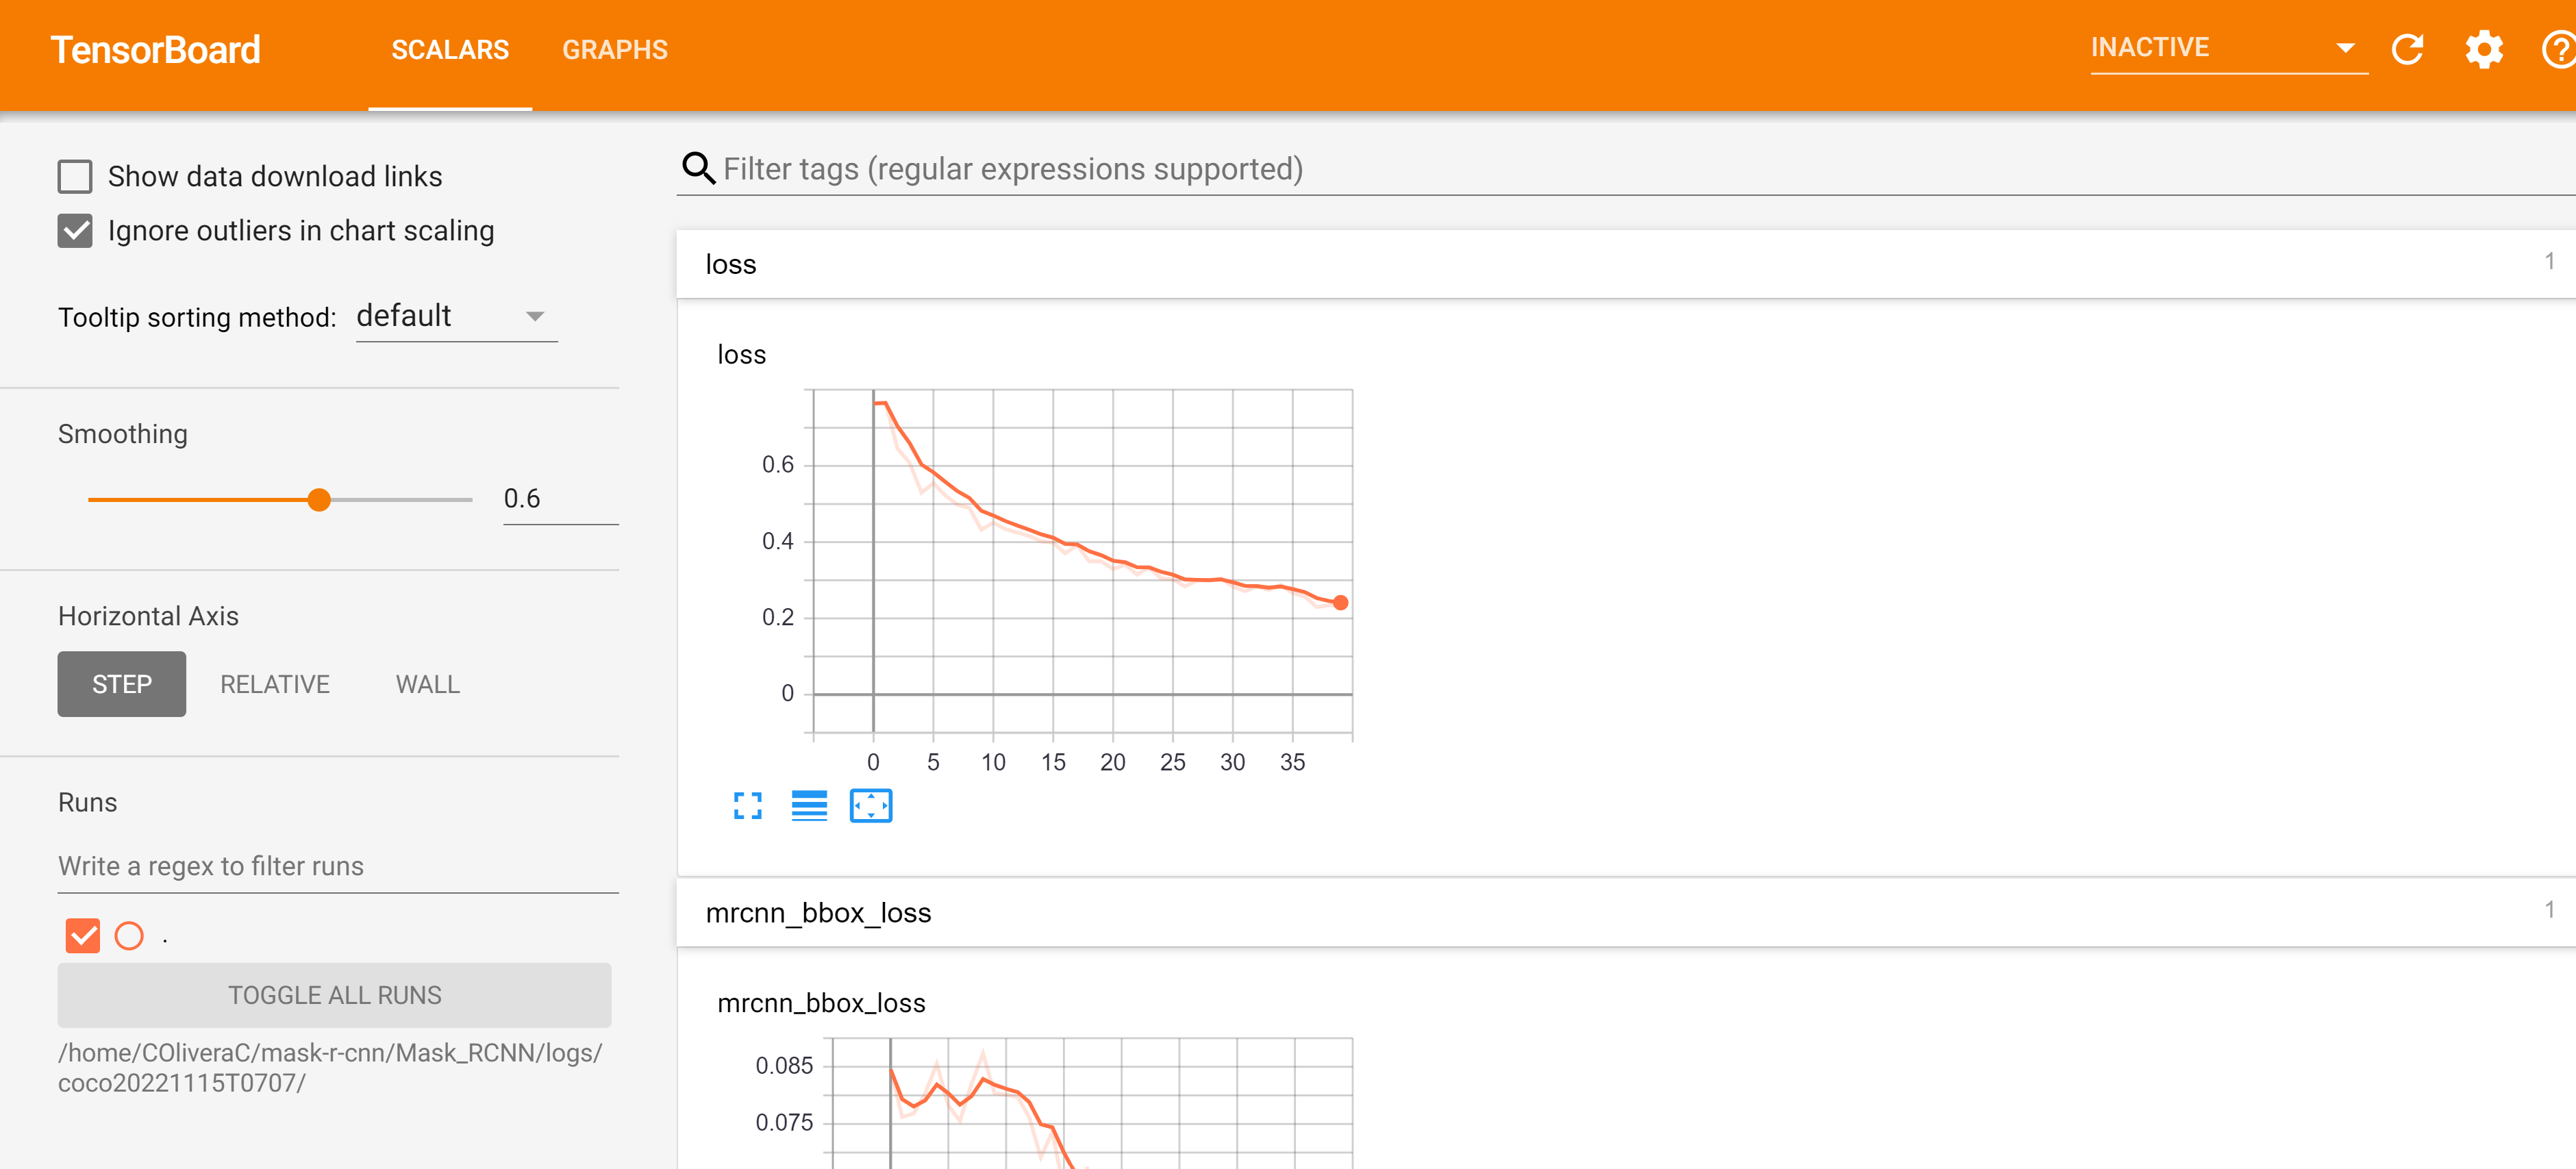

In [3]:
from IPython.display import Image
Image(filename='imagen1.png') 

## Detectar objetos usando modelo entrenado

image ID: coco.25821 (564) http://cocodataset.org/#explore?id=25821
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (5,)                  min:    3.00000  max:   55.00000  int32
gt_bbox                  shape: (5, 4)                min:  128.00000  max:  896.00000  int32
gt_mask                  shape: (1024, 1024, 5)       min:    0.00000  max:    1.00000  bool


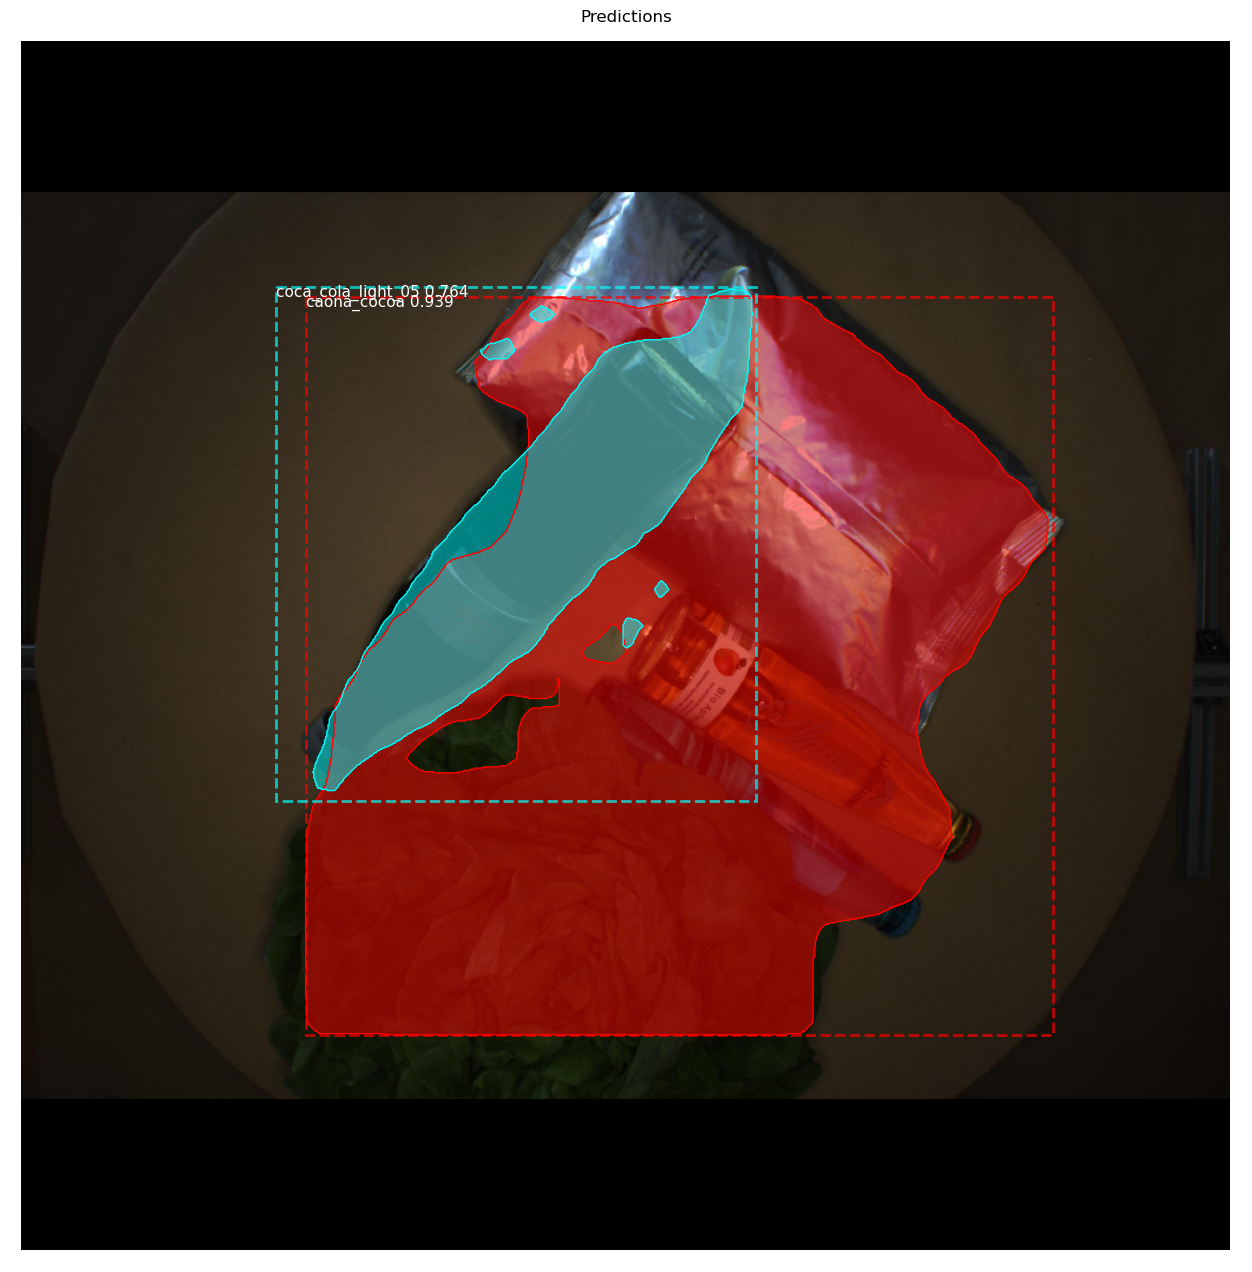

In [20]:
# Se utilizará una imagen aleatoria del conjunto de validación
image_id = random.choice(dataset_val.image_ids)

# Se calcula
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))
# Aplicar la detección de objetos
results = model_inf.detect([image], verbose=1)

# Mostrar los resultados
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)